In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:0


In [2]:
def true_smooth(x): #[-3,3]
    term1 = (np.power(x,3) - x)
    term2 = np.sin(7*x)/7  

    
    term3 = np.sin(12*x)*np.exp(abs(x))
    term12 = np.multiply(term1,term2)

    return 50*(term12  + term3)

In [3]:
# Domain bounds
label = "Regr_smooth_rowdy"
loss_thresh = 0.1


lb = np.array(-3.0)  # [-1. 0.]
ub = np.array(3.0) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_smooth(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [4]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_smooth(x_train)

    return x_train, u_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers,n_val, rowdy_terms):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        self.omega1 = Parameter(torch.ones((len(layers)-2,1))) 

        
        self.alpha = Parameter(torch.zeros(rowdy_terms,len(layers)-2))
        self.omega = Parameter((1/n_val)*torch.ones(rowdy_terms,len(layers)-2))
        
        self.n = torch.tensor(n_val)
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.omega1[i,0]*z)
            for j in range(rowdy_terms):
                a = a + self.alpha[j,i]*self.n*torch.sin((j+1)*self.n*self.omega[j,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    alpha_val.append(model_NN.alpha.cpu().detach().numpy())
    omega_val.append(model_NN.alpha.cpu().detach().numpy())    
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [8]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 5
max_iter = 3000
layers = np.array([1,50,50,50,50,1])

train_loss_full = []
test_mse_full = []
test_re_full = []
alpha_full = []
omega_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

n_val = 1
rowdy_terms = 8


for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
    alpha_val = []
    omega_val = []
    'Generate Training data'
    N_train = 300
    
    x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

    'Convert to tensor and send to GPU'
    x_train = torch.from_numpy(x_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
       
     
    model_NN = Sequentialmodel(layers,n_val, rowdy_terms)
    model_NN.to(device)
    print(model_NN)
    params = list(model_NN.parameters())
    #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model_NN.parameters(), lr=8.0e-4)

    train_model(max_iter,reps)
 
    torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    alpha_full.append(alpha_val)
    omega_full.append(alpha_val)
                 

mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold,"alpha": alpha_full,"omega": omega_full, "label": label}
savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 73260.164 Test MSE 85809.21675644052 Test RE 0.9999891839756402
1 Train Loss 73249.8 Test MSE 85808.12303783259 Test RE 0.9999828110572947
2 Train Loss 73238.22 Test MSE 85806.96245331485 Test RE 0.9999760484778805
3 Train Loss 73225.53 Test MSE 85805.7617222667 Test RE 0.99996905192157
4 Train Loss 73211.91 Test MSE 85804.5490287109 Test RE 0.9999619856110706
5 Train Loss 73197.56 Test MSE 85803.34972749594 Test RE 0.9999549972880248
6 Train Loss 73182.66 Test MSE 85802.18167540192 Test RE 0.999948191006526
7 Train Loss 73167.336 Test MSE 85801.05674437087 Test RE 0.9999416359492

112 Train Loss 72304.016 Test MSE 85797.5923465009 Test RE 0.9999214483735936
113 Train Loss 72292.38 Test MSE 85796.22519126038 Test RE 0.9999134816389992
114 Train Loss 72280.484 Test MSE 85794.22377630472 Test RE 0.9999018188096428
115 Train Loss 72268.34 Test MSE 85791.72975223008 Test RE 0.9998872852127272
116 Train Loss 72255.92 Test MSE 85788.78444780633 Test RE 0.9998701215669468
117 Train Loss 72243.34 Test MSE 85785.85761227753 Test RE 0.9998530652560578
118 Train Loss 72230.68 Test MSE 85783.29755681682 Test RE 0.9998381461396211
119 Train Loss 72218.09 Test MSE 85781.4635771843 Test RE 0.9998274582047384
120 Train Loss 72205.5 Test MSE 85779.43493550285 Test RE 0.9998156356992502
121 Train Loss 72193.336 Test MSE 85776.35201416149 Test RE 0.9997976688015981
122 Train Loss 72182.21 Test MSE 85773.65304566931 Test RE 0.9997819392702637
123 Train Loss 72169.55 Test MSE 85769.60936802762 Test RE 0.9997583723392776
124 Train Loss 72154.77 Test MSE 85766.22300676847 Test RE 0.999

224 Train Loss 69639.47 Test MSE 83899.46041916047 Test RE 0.9887987701699622
225 Train Loss 69470.484 Test MSE 83893.59145171841 Test RE 0.9887641851484922
226 Train Loss 69434.375 Test MSE 83803.14151844582 Test RE 0.988231023009623
227 Train Loss 69441.62 Test MSE 83701.81843020397 Test RE 0.9876334266567682
228 Train Loss 69253.76 Test MSE 83804.94148558345 Test RE 0.9882416358206841
229 Train Loss 69334.06 Test MSE 83575.21858722183 Test RE 0.9868862412684534
230 Train Loss 69183.56 Test MSE 83524.28979235333 Test RE 0.9865855026818019
231 Train Loss 69136.49 Test MSE 83612.03290087277 Test RE 0.9871035756659583
232 Train Loss 69144.03 Test MSE 83422.59838623085 Test RE 0.9859847323958879
233 Train Loss 69041.71 Test MSE 83341.46045170307 Test RE 0.9855051247827865
234 Train Loss 68946.336 Test MSE 83348.86388851139 Test RE 0.985548896291288
235 Train Loss 68932.96 Test MSE 83254.39108644048 Test RE 0.9849901966287531
236 Train Loss 68932.33 Test MSE 83297.38644773244 Test RE 0.98

331 Train Loss 62597.395 Test MSE 76234.7102489507 Test RE 0.9425506791544271
332 Train Loss 62662.496 Test MSE 76191.68562199875 Test RE 0.9422846676843818
333 Train Loss 62743.254 Test MSE 76325.54114116236 Test RE 0.943112019473889
334 Train Loss 62774.434 Test MSE 76058.90228762096 Test RE 0.9414632246368784
335 Train Loss 62632.816 Test MSE 75951.82841642931 Test RE 0.9408003067396585
336 Train Loss 62407.934 Test MSE 75676.76949534917 Test RE 0.9390952113109212
337 Train Loss 62176.082 Test MSE 75567.62575975488 Test RE 0.9384177686638926
338 Train Loss 62044.066 Test MSE 75530.98242744795 Test RE 0.9381902180203031
339 Train Loss 61999.293 Test MSE 75483.94640756543 Test RE 0.9378980491339017
340 Train Loss 62018.574 Test MSE 75599.36414570101 Test RE 0.9386148156028
341 Train Loss 62078.742 Test MSE 75513.82733856511 Test RE 0.9380836680321325
342 Train Loss 62131.3 Test MSE 75625.02556128376 Test RE 0.9387741035910209
343 Train Loss 62129.723 Test MSE 75326.24100993965 Test RE

441 Train Loss 54910.633 Test MSE 67748.94745455316 Test RE 0.8885453734744369
442 Train Loss 54989.953 Test MSE 67998.85356116411 Test RE 0.8901826573575249
443 Train Loss 55031.996 Test MSE 67642.49905024249 Test RE 0.8878470495663688
444 Train Loss 54911.77 Test MSE 67610.55149363053 Test RE 0.8876373596952652
445 Train Loss 54636.195 Test MSE 67169.36525188068 Test RE 0.8847365229615562
446 Train Loss 54331.312 Test MSE 67058.27470861243 Test RE 0.8840045930655019
447 Train Loss 54110.227 Test MSE 66895.16499180291 Test RE 0.8829288307787746
448 Train Loss 53990.402 Test MSE 66826.60642921849 Test RE 0.8824762730427953
449 Train Loss 53948.594 Test MSE 66871.11637236079 Test RE 0.8827701113248956
450 Train Loss 53950.785 Test MSE 66777.90386697411 Test RE 0.8821546444923667
451 Train Loss 53989.46 Test MSE 66962.0609209176 Test RE 0.8833701899234013
452 Train Loss 54055.73 Test MSE 66816.35446542565 Test RE 0.8824085794826105
453 Train Loss 54148.594 Test MSE 67148.12950046592 Test

550 Train Loss 46849.316 Test MSE 58757.93370946868 Test RE 0.8274877840957575
551 Train Loss 46523.062 Test MSE 58146.2730196803 Test RE 0.8231695088318232
552 Train Loss 46129.527 Test MSE 58024.39963296993 Test RE 0.8223063831809656
553 Train Loss 45832.996 Test MSE 57800.859466406764 Test RE 0.8207208787207783
554 Train Loss 45664.887 Test MSE 57694.474385754096 Test RE 0.819965244026734
555 Train Loss 45607.94 Test MSE 57777.196288753716 Test RE 0.8205528634678311
556 Train Loss 45620.273 Test MSE 57656.738216018435 Test RE 0.8196970432222489
557 Train Loss 45676.61 Test MSE 57888.091161551805 Test RE 0.8213399515420683
558 Train Loss 45744.047 Test MSE 57707.96129460401 Test RE 0.8200610777301481
559 Train Loss 45856.758 Test MSE 58169.43477782475 Test RE 0.8233334415637875
560 Train Loss 46042.51 Test MSE 57783.967850848865 Test RE 0.8206009469871842
561 Train Loss 45977.316 Test MSE 57925.31885474553 Test RE 0.8216040099758248
562 Train Loss 45795.195 Test MSE 57269.11366108172

658 Train Loss 37562.113 Test MSE 48704.37108292208 Test RE 0.7533769065763164
659 Train Loss 37470.426 Test MSE 48636.826140955534 Test RE 0.7528543204772767
660 Train Loss 37461.242 Test MSE 48774.79239716867 Test RE 0.7539213610783333
661 Train Loss 37539.418 Test MSE 48725.595158927186 Test RE 0.7535410395563188
662 Train Loss 37674.516 Test MSE 49139.503322560384 Test RE 0.7567348150223856
663 Train Loss 37896.516 Test MSE 48918.779553158354 Test RE 0.7550333596080434
664 Train Loss 38008.984 Test MSE 49349.317119547515 Test RE 0.7583486315444845
665 Train Loss 38123.85 Test MSE 48882.96006847375 Test RE 0.7547568823670857
666 Train Loss 38027.684 Test MSE 49057.1958129529 Test RE 0.7561007929304887
667 Train Loss 37783.375 Test MSE 48334.24505666611 Test RE 0.7505088253086256
668 Train Loss 37362.96 Test MSE 48218.760742509854 Test RE 0.749611699163016
669 Train Loss 36971.453 Test MSE 47797.86295542273 Test RE 0.7463328774213207
670 Train Loss 36699.395 Test MSE 47699.5248173995

769 Train Loss 30526.848 Test MSE 40227.88278452559 Test RE 0.6846867471489438
770 Train Loss 30165.46 Test MSE 40093.247296646 Test RE 0.683540025182808
771 Train Loss 29856.89 Test MSE 39767.59527039939 Test RE 0.6807583841804934
772 Train Loss 29659.967 Test MSE 39738.77781984307 Test RE 0.6805116848740578
773 Train Loss 29582.46 Test MSE 39654.71606744358 Test RE 0.6797915408207116
774 Train Loss 29529.975 Test MSE 39564.7838505125 Test RE 0.6790202597780517
775 Train Loss 29467.678 Test MSE 39555.870891725135 Test RE 0.6789437723075517
776 Train Loss 29444.182 Test MSE 39494.02932169216 Test RE 0.6784128350368568
777 Train Loss 29487.748 Test MSE 39685.57343502074 Test RE 0.6800559797119728
778 Train Loss 29602.805 Test MSE 39642.58607282209 Test RE 0.6796875620354498
779 Train Loss 29761.88 Test MSE 40155.9220139223 Test RE 0.6840740795609717
780 Train Loss 30060.207 Test MSE 40111.27274343102 Test RE 0.6836936636460739
781 Train Loss 30421.854 Test MSE 40914.61943734769 Test RE 

879 Train Loss 24150.135 Test MSE 32650.762141628 Test RE 0.6168435036355556
880 Train Loss 23711.672 Test MSE 32522.919337096482 Test RE 0.6156347057067117
881 Train Loss 23357.283 Test MSE 32156.728486604647 Test RE 0.6121590340551095
882 Train Loss 23110.729 Test MSE 32049.625640845174 Test RE 0.6111387396800352
883 Train Loss 22991.896 Test MSE 32068.923287341884 Test RE 0.6113227007151893
884 Train Loss 22984.156 Test MSE 31997.615863334446 Test RE 0.6106426637527766
885 Train Loss 23051.252 Test MSE 32225.43665355575 Test RE 0.6128126745815519
886 Train Loss 23164.234 Test MSE 32141.449441641544 Test RE 0.612013585230902
887 Train Loss 23310.68 Test MSE 32562.943609596336 Test RE 0.6160134041060233
888 Train Loss 23539.123 Test MSE 32527.76099418137 Test RE 0.6156805284875441
889 Train Loss 23799.13 Test MSE 33070.62790973378 Test RE 0.6207969208511909
890 Train Loss 24095.355 Test MSE 32768.738633737106 Test RE 0.6179569143042387
891 Train Loss 24091.467 Test MSE 32938.921471053

997 Train Loss 17556.22 Test MSE 25571.18568631204 Test RE 0.5458882754315852
998 Train Loss 17648.861 Test MSE 25525.640803941264 Test RE 0.5454019175033564
999 Train Loss 17792.998 Test MSE 25885.90098308169 Test RE 0.5492372405321693
1000 Train Loss 18004.477 Test MSE 25860.522076212277 Test RE 0.5489679344923631
1001 Train Loss 18241.602 Test MSE 26357.7643286769 Test RE 0.5542205423095551
1002 Train Loss 18514.143 Test MSE 26188.71691044882 Test RE 0.5524404168126867
1003 Train Loss 18655.566 Test MSE 26553.998636899858 Test RE 0.556279810472636
1004 Train Loss 18709.734 Test MSE 26014.760875306383 Test RE 0.5506025936494059
1005 Train Loss 18447.748 Test MSE 25956.535246423966 Test RE 0.5499860755683046
1006 Train Loss 18096.293 Test MSE 25342.594858619406 Test RE 0.5434428436214442
1007 Train Loss 17641.264 Test MSE 25117.69246058071 Test RE 0.5410260829723645
1008 Train Loss 17293.496 Test MSE 24850.47842769374 Test RE 0.5381405408134946
1009 Train Loss 17064.148 Test MSE 24706

1107 Train Loss 14327.846 Test MSE 21069.70734471064 Test RE 0.4955158894984686
1108 Train Loss 14560.834 Test MSE 21525.83633538702 Test RE 0.5008507756306136
1109 Train Loss 14766.74 Test MSE 21184.267622425774 Test RE 0.49686117359253085
1110 Train Loss 14705.757 Test MSE 21288.10123751357 Test RE 0.4980773550930916
1111 Train Loss 14508.365 Test MSE 20659.0266555079 Test RE 0.49066294558712475
1112 Train Loss 14093.334 Test MSE 20479.199934996457 Test RE 0.4885227876981467
1113 Train Loss 13696.437 Test MSE 20029.04240113095 Test RE 0.4831237934670122
1114 Train Loss 13363.202 Test MSE 19899.74522801082 Test RE 0.48156186955739577
1115 Train Loss 13150.254 Test MSE 19731.832774063547 Test RE 0.47952587535697766
1116 Train Loss 13039.55 Test MSE 19694.344430342528 Test RE 0.4790701351939203
1117 Train Loss 13006.105 Test MSE 19703.07455143176 Test RE 0.4791763046813174
1118 Train Loss 13029.232 Test MSE 19702.905144345103 Test RE 0.47917424469732744
1119 Train Loss 13095.703 Test MS

1215 Train Loss 10312.216 Test MSE 16167.861220380806 Test RE 0.43406485137478423
1216 Train Loss 10405.507 Test MSE 16153.669517296217 Test RE 0.4338743044683141
1217 Train Loss 10548.112 Test MSE 16505.953593243416 Test RE 0.43857981858374623
1218 Train Loss 10760.778 Test MSE 16511.119011650528 Test RE 0.4386484384015572
1219 Train Loss 11013.577 Test MSE 17028.694705705 Test RE 0.4454705656351648
1220 Train Loss 11318.703 Test MSE 16958.73187330412 Test RE 0.4445545100899612
1221 Train Loss 11560.249 Test MSE 17418.465324100976 Test RE 0.45053992026169776
1222 Train Loss 11708.174 Test MSE 16982.955994725362 Test RE 0.44487190114323466
1223 Train Loss 11592.668 Test MSE 17038.34538862848 Test RE 0.44559677866324143
1224 Train Loss 11305.872 Test MSE 16363.11265060611 Test RE 0.4366779811763762
1225 Train Loss 10857.173 Test MSE 16162.787250815567 Test RE 0.43399673461401006
1226 Train Loss 10442.535 Test MSE 15733.338999303467 Test RE 0.4281922315392301
1227 Train Loss 10121.817 Te

1325 Train Loss 8635.311 Test MSE 13128.987651078472 Test RE 0.3911505575409086
1326 Train Loss 8258.622 Test MSE 12729.287372058574 Test RE 0.385150423063427
1327 Train Loss 7968.2085 Test MSE 12617.939586022003 Test RE 0.3834621964472579
1328 Train Loss 7782.5137 Test MSE 12473.056364205553 Test RE 0.38125432241922524
1329 Train Loss 7687.737 Test MSE 12435.70119320831 Test RE 0.38068299093937685
1330 Train Loss 7660.2695 Test MSE 12477.3685946277 Test RE 0.3813202210396985
1331 Train Loss 7684.6045 Test MSE 12453.0860216493 Test RE 0.3809489911033009
1332 Train Loss 7754.056 Test MSE 12662.477571228725 Test RE 0.3841383603047668
1333 Train Loss 7871.095 Test MSE 12645.548003770456 Test RE 0.3838814804245298
1334 Train Loss 8033.5396 Test MSE 13020.864929599535 Test RE 0.38953658325943225
1335 Train Loss 8258.313 Test MSE 13021.34454535575 Test RE 0.3895437573666661
1336 Train Loss 8516.374 Test MSE 13555.642383201695 Test RE 0.3974553847539839
1337 Train Loss 8815.721 Test MSE 13433

1430 Train Loss 6886.6816 Test MSE 10436.611008441529 Test RE 0.34874507413366373
1431 Train Loss 6497.4824 Test MSE 10298.742474749339 Test RE 0.3464339398987058
1432 Train Loss 6195.406 Test MSE 9999.646359547834 Test RE 0.34136630740696416
1433 Train Loss 6000.594 Test MSE 9965.329931459873 Test RE 0.3407800596774405
1434 Train Loss 5900.0444 Test MSE 9882.913508867572 Test RE 0.3393679546725098
1435 Train Loss 5863.3784 Test MSE 9877.171529043966 Test RE 0.33926935383633455
1436 Train Loss 5866.0146 Test MSE 9925.905064657683 Test RE 0.34010529411488233
1437 Train Loss 5894.895 Test MSE 9897.250880454203 Test RE 0.33961402993510564
1438 Train Loss 5951.147 Test MSE 10079.191450062955 Test RE 0.34272136664841457
1439 Train Loss 6045.1377 Test MSE 10047.333079116706 Test RE 0.34217930005521247
1440 Train Loss 6186.691 Test MSE 10423.46705927438 Test RE 0.348525398815764
1441 Train Loss 6395.403 Test MSE 10395.881512458447 Test RE 0.3480639097026611
1442 Train Loss 6647.134 Test MSE 1

1540 Train Loss 4922.852 Test MSE 7972.163017728621 Test RE 0.30480102214447596
1541 Train Loss 4653.3125 Test MSE 7909.666899160423 Test RE 0.3036039592980635
1542 Train Loss 4491.968 Test MSE 7775.529013971738 Test RE 0.3010185828545498
1543 Train Loss 4412.659 Test MSE 7747.724514823427 Test RE 0.30047989496617794
1544 Train Loss 4391.2715 Test MSE 7798.1017832952075 Test RE 0.30145520258381275
1545 Train Loss 4412.7334 Test MSE 7762.85682402244 Test RE 0.3007731898966915
1546 Train Loss 4470.476 Test MSE 7956.4952791065925 Test RE 0.3045013612246559
1547 Train Loss 4567.4487 Test MSE 7925.838999195373 Test RE 0.30391417504571494
1548 Train Loss 4710.1577 Test MSE 8289.161002551384 Test RE 0.3108018686508164
1549 Train Loss 4913.7485 Test MSE 8274.261539401228 Test RE 0.3105224155327862
1550 Train Loss 5174.5884 Test MSE 8861.215562802452 Test RE 0.3213475436013985
1551 Train Loss 5500.2837 Test MSE 8772.65857227065 Test RE 0.3197377741333352
1552 Train Loss 5803.613 Test MSE 9409.5

1645 Train Loss 4836.4824 Test MSE 7319.203504174564 Test RE 0.2920520405378906
1646 Train Loss 4423.0576 Test MSE 6684.292519968893 Test RE 0.27909757136184626
1647 Train Loss 4009.264 Test MSE 6569.051804836106 Test RE 0.2766812168888723
1648 Train Loss 3684.1655 Test MSE 6258.228584730465 Test RE 0.2700561330367305
1649 Train Loss 3473.505 Test MSE 6197.493206813347 Test RE 0.2687425064939068
1650 Train Loss 3355.546 Test MSE 6138.912285241711 Test RE 0.26746936567784874
1651 Train Loss 3305.2656 Test MSE 6079.565920565525 Test RE 0.2661733800711153
1652 Train Loss 3302.4663 Test MSE 6197.861657114912 Test RE 0.2687504949484806
1653 Train Loss 3337.2234 Test MSE 6114.30567434038 Test RE 0.2669327785165014
1654 Train Loss 3406.2146 Test MSE 6381.315639420272 Test RE 0.2726989382637165
1655 Train Loss 3519.8535 Test MSE 6306.604106129225 Test RE 0.27109787808426095
1656 Train Loss 3682.4126 Test MSE 6761.760448220897 Test RE 0.2807102196898926
1657 Train Loss 3918.5906 Test MSE 6706.4

1754 Train Loss 3543.7559 Test MSE 5319.2800213976825 Test RE 0.2489744378033913
1755 Train Loss 3132.2922 Test MSE 5249.133588172484 Test RE 0.24732735125720898
1756 Train Loss 2819.2026 Test MSE 4908.116776808141 Test RE 0.23915847600153145
1757 Train Loss 2616.9558 Test MSE 4909.279142177923 Test RE 0.239186793693047
1758 Train Loss 2508.0586 Test MSE 4799.333655140121 Test RE 0.23649328044905732
1759 Train Loss 2463.8872 Test MSE 4806.829266441179 Test RE 0.23667788629603287
1760 Train Loss 2463.1978 Test MSE 4852.83594213059 Test RE 0.23780782369569772
1761 Train Loss 2493.6067 Test MSE 4823.0809492943345 Test RE 0.23707764756045582
1762 Train Loss 2552.859 Test MSE 5022.119480268244 Test RE 0.24192004469615647
1763 Train Loss 2647.873 Test MSE 4964.438271258631 Test RE 0.2405267544630773
1764 Train Loss 2790.363 Test MSE 5389.176798009796 Test RE 0.2506048948122525
1765 Train Loss 3002.1055 Test MSE 5311.049606087928 Test RE 0.2487817466602829
1766 Train Loss 3271.6804 Test MSE 6

1863 Train Loss 2740.3918 Test MSE 4386.930833516321 Test RE 0.226104250824493
1864 Train Loss 2378.1414 Test MSE 4026.2096458728784 Test RE 0.21660901436392727
1865 Train Loss 2130.6252 Test MSE 3962.2043354405296 Test RE 0.2148803823662078
1866 Train Loss 1977.5367 Test MSE 3859.6871083997075 Test RE 0.21208227986162523
1867 Train Loss 1898.0317 Test MSE 3803.3225227516587 Test RE 0.2105280225968406
1868 Train Loss 1867.4186 Test MSE 3865.3091144703294 Test RE 0.2122366827914755
1869 Train Loss 1873.1152 Test MSE 3790.7727528376035 Test RE 0.2101803974166686
1870 Train Loss 1910.2054 Test MSE 3975.0899623393743 Test RE 0.2152295088460515
1871 Train Loss 1982.0177 Test MSE 3909.2268221479894 Test RE 0.21343899565648455
1872 Train Loss 2094.356 Test MSE 4249.616025717271 Test RE 0.22253748688953334
1873 Train Loss 2265.4578 Test MSE 4204.473939204567 Test RE 0.22135236483581963
1874 Train Loss 2499.3975 Test MSE 4782.957821113669 Test RE 0.2360894656473703
1875 Train Loss 2812.9614 Tes

1976 Train Loss 1481.49 Test MSE 3060.314532665217 Test RE 0.18884755483209523
1977 Train Loss 1430.7073 Test MSE 3047.4183645120183 Test RE 0.18844923287508372
1978 Train Loss 1427.936 Test MSE 3106.9014555484487 Test RE 0.19027953129679387
1979 Train Loss 1460.5319 Test MSE 3089.363540189469 Test RE 0.18974172392722988
1980 Train Loss 1521.7252 Test MSE 3260.2002974875554 Test RE 0.1949173395704622
1981 Train Loss 1613.53 Test MSE 3230.4074482145193 Test RE 0.19402468416896101
1982 Train Loss 1750.3196 Test MSE 3613.2081103629216 Test RE 0.2051988024579562
1983 Train Loss 1951.8422 Test MSE 3559.1698092612223 Test RE 0.20365856911085292
1984 Train Loss 2218.9822 Test MSE 4238.984033710264 Test RE 0.22225893248732623
1985 Train Loss 2572.188 Test MSE 4061.0920973898747 Test RE 0.21754532406146038
1986 Train Loss 2876.5862 Test MSE 4799.641349877021 Test RE 0.23650086135264226
1987 Train Loss 3142.5566 Test MSE 4265.173320213193 Test RE 0.22294445524005382
1988 Train Loss 3113.5645 Tes

2084 Train Loss 1401.5632 Test MSE 2578.2342129435233 Test RE 0.1733362981285748
2085 Train Loss 1246.2384 Test MSE 2558.8385937293374 Test RE 0.17268307748905112
2086 Train Loss 1162.9767 Test MSE 2507.3819149351007 Test RE 0.1709379842183266
2087 Train Loss 1130.3169 Test MSE 2478.2310856526374 Test RE 0.1699414164798145
2088 Train Loss 1131.5723 Test MSE 2561.624329478356 Test RE 0.17277704952940548
2089 Train Loss 1159.9734 Test MSE 2506.1627056893353 Test RE 0.17089642004528152
2090 Train Loss 1214.4891 Test MSE 2708.8065757661016 Test RE 0.17767132093918403
2091 Train Loss 1302.962 Test MSE 2650.949388360985 Test RE 0.17576364557393245
2092 Train Loss 1434.8071 Test MSE 3035.1316011615936 Test RE 0.18806894873932398
2093 Train Loss 1635.3932 Test MSE 2994.1342212611476 Test RE 0.18679444905464604
2094 Train Loss 1898.0497 Test MSE 3618.643140793937 Test RE 0.2053530756992659
2095 Train Loss 2235.6926 Test MSE 3485.5673509833277 Test RE 0.20154177224117723
2096 Train Loss 2539.893

2187 Train Loss 1296.8707 Test MSE 2768.991076539404 Test RE 0.17963423623397345
2188 Train Loss 1523.2421 Test MSE 2669.454990110925 Test RE 0.1763760592537891
2189 Train Loss 1793.8201 Test MSE 3423.2048747652425 Test RE 0.19973067956979795
2190 Train Loss 2179.8088 Test MSE 3193.8544399993007 Test RE 0.19292383809220648
2191 Train Loss 2463.5874 Test MSE 3950.6599251341418 Test RE 0.21456711269779488
2192 Train Loss 2721.0576 Test MSE 3311.652191883958 Test RE 0.19644939377018864
2193 Train Loss 2584.6995 Test MSE 3478.188701098371 Test RE 0.2013283358220499
2194 Train Loss 2280.315 Test MSE 2757.802925384465 Test RE 0.1792709614570848
2195 Train Loss 1846.5701 Test MSE 2659.4787455344635 Test RE 0.17604617585997945
2196 Train Loss 1477.9225 Test MSE 2332.5500570311997 Test RE 0.1648708283675715
2197 Train Loss 1244.3302 Test MSE 2257.6559048894924 Test RE 0.1622023750382765
2198 Train Loss 1096.5198 Test MSE 2173.9828514928363 Test RE 0.1591682314287239
2199 Train Loss 1006.3649 Te

2296 Train Loss 798.69196 Test MSE 1775.7358249796343 Test RE 0.14385253250045849
2297 Train Loss 769.00854 Test MSE 1774.4787516197578 Test RE 0.1438016056680823
2298 Train Loss 768.4972 Test MSE 1771.306023674939 Test RE 0.14367299114025797
2299 Train Loss 789.56177 Test MSE 1837.69645271419 Test RE 0.14634073171574713
2300 Train Loss 827.2823 Test MSE 1818.804373866777 Test RE 0.14558657483714768
2301 Train Loss 883.8779 Test MSE 1992.287506778527 Test RE 0.15237170930900837
2302 Train Loss 968.3608 Test MSE 1952.4771415986643 Test RE 0.15084166334487203
2303 Train Loss 1097.9917 Test MSE 2333.8608038916445 Test RE 0.16491714539500768
2304 Train Loss 1300.8546 Test MSE 2281.512470748472 Test RE 0.16305711619538002
2305 Train Loss 1558.5278 Test MSE 2950.8888259473038 Test RE 0.18544057174851677
2306 Train Loss 1919.4454 Test MSE 2779.233869024891 Test RE 0.17996617262265185
2307 Train Loss 2201.455 Test MSE 3488.470271114164 Test RE 0.20162568080531604
2308 Train Loss 2465.2568 Test

2401 Train Loss 691.2275 Test MSE 1542.2298279241588 Test RE 0.1340611322213774
2402 Train Loss 723.6194 Test MSE 1673.763596495917 Test RE 0.13966107889148432
2403 Train Loss 778.778 Test MSE 1625.8578617196747 Test RE 0.13764790993007864
2404 Train Loss 871.21063 Test MSE 1933.6292140074058 Test RE 0.15011183474784173
2405 Train Loss 1025.5964 Test MSE 1881.0462771829864 Test RE 0.14805670289545625
2406 Train Loss 1234.7421 Test MSE 2469.4573949490314 Test RE 0.16964032764353987
2407 Train Loss 1557.8093 Test MSE 2369.625935150261 Test RE 0.1661759732262643
2408 Train Loss 1867.3934 Test MSE 3132.7697104814124 Test RE 0.19107002888609734
2409 Train Loss 2244.7573 Test MSE 2755.269411960446 Test RE 0.179188597024355
2410 Train Loss 2332.522 Test MSE 3087.6897561985297 Test RE 0.18969031694910835
2411 Train Loss 2238.96 Test MSE 2421.030496752618 Test RE 0.16796873974660909
2412 Train Loss 1887.4938 Test MSE 2325.20574393532 Test RE 0.16461106596279185
2413 Train Loss 1469.9784 Test MS

2508 Train Loss 646.79675 Test MSE 1385.147718612053 Test RE 0.12705050020492575
2509 Train Loss 720.6723 Test MSE 1635.5734050493757 Test RE 0.13805856462786453
2510 Train Loss 844.47174 Test MSE 1592.893568400177 Test RE 0.13624535758016368
2511 Train Loss 1022.30505 Test MSE 2117.8825117891274 Test RE 0.1571011144312018
2512 Train Loss 1313.3032 Test MSE 2046.8319481021572 Test RE 0.1544434260971342
2513 Train Loss 1613.6389 Test MSE 2808.097989597731 Test RE 0.18089829059377652
2514 Train Loss 2028.5315 Test MSE 2531.7564618237716 Test RE 0.17176682863241657
2515 Train Loss 2213.8462 Test MSE 2987.1657430837863 Test RE 0.18657695190870296
2516 Train Loss 2263.5977 Test MSE 2384.3346595960893 Test RE 0.16669091850265808
2517 Train Loss 2003.2393 Test MSE 2307.8320369644325 Test RE 0.1639949340969743
2518 Train Loss 1574.7529 Test MSE 1734.1400059247328 Test RE 0.14215770787831472
2519 Train Loss 1178.6521 Test MSE 1675.2532815744257 Test RE 0.13972321572904076
2520 Train Loss 897.53

2619 Train Loss 737.3479 Test MSE 1388.4000681200664 Test RE 0.12719957107770252
2620 Train Loss 889.74316 Test MSE 1837.0418934704303 Test RE 0.14631466723440284
2621 Train Loss 1153.7695 Test MSE 1851.4397556854803 Test RE 0.14688692060928432
2622 Train Loss 1493.2395 Test MSE 2578.1953805279463 Test RE 0.17333499275987027
2623 Train Loss 1948.3018 Test MSE 2489.1447495337 Test RE 0.17031520044089404
2624 Train Loss 2285.3662 Test MSE 3065.956516654044 Test RE 0.1890215539823686
2625 Train Loss 2414.028 Test MSE 2265.233740946609 Test RE 0.1624743636358882
2626 Train Loss 2000.9419 Test MSE 2238.269311913845 Test RE 0.16150445398678479
2627 Train Loss 1554.0226 Test MSE 1521.3813704573267 Test RE 0.13315190390260032
2628 Train Loss 1071.1842 Test MSE 1436.310742709405 Test RE 0.12937564800810003
2629 Train Loss 768.2345 Test MSE 1195.9614150870268 Test RE 0.11805568837524769
2630 Train Loss 606.1401 Test MSE 1190.0013505370355 Test RE 0.11776115615786498
2631 Train Loss 523.19666 Tes

2725 Train Loss 2040.1981 Test MSE 1899.3320864253972 Test RE 0.14877459827219178
2726 Train Loss 1647.3544 Test MSE 1973.9315920875645 Test RE 0.1516681476269355
2727 Train Loss 1355.0521 Test MSE 1361.680274513239 Test RE 0.1259696453986182
2728 Train Loss 947.79755 Test MSE 1252.26303664836 Test RE 0.12080255352455607
2729 Train Loss 670.91656 Test MSE 1113.039106545261 Test RE 0.1138894630630495
2730 Train Loss 562.1736 Test MSE 1089.548326616031 Test RE 0.11268123096612892
2731 Train Loss 513.5482 Test MSE 1048.5694666997272 Test RE 0.11054190315230761
2732 Train Loss 458.98434 Test MSE 993.6098299775679 Test RE 0.10760594687511012
2733 Train Loss 416.38153 Test MSE 988.1111312955068 Test RE 0.10730778478501092
2734 Train Loss 415.26556 Test MSE 1018.8397259478514 Test RE 0.10896355624615763
2735 Train Loss 451.8352 Test MSE 1064.29415406561 Test RE 0.11136767986183438
2736 Train Loss 498.05783 Test MSE 1050.8293754263125 Test RE 0.11066096066941218
2737 Train Loss 540.6817 Test M

2833 Train Loss 1210.1909 Test MSE 1533.5979783261812 Test RE 0.13368543618037015
2834 Train Loss 949.9929 Test MSE 1068.512535539215 Test RE 0.11158816719879236
2835 Train Loss 694.30927 Test MSE 1090.1976003529485 Test RE 0.11271479995339406
2836 Train Loss 565.7641 Test MSE 956.972281948448 Test RE 0.10560342728756353
2837 Train Loss 502.9881 Test MSE 973.1662718435557 Test RE 0.10649319527927972
2838 Train Loss 456.59412 Test MSE 890.9537584916277 Test RE 0.1018957137642994
2839 Train Loss 423.1383 Test MSE 937.9236503623943 Test RE 0.10454712085967213
2840 Train Loss 401.2219 Test MSE 865.1145924566905 Test RE 0.10040726847806698
2841 Train Loss 399.54346 Test MSE 945.1637698073849 Test RE 0.10494986073233598
2842 Train Loss 409.9195 Test MSE 870.6372720516322 Test RE 0.10072724632591867
2843 Train Loss 414.4866 Test MSE 973.8165706440232 Test RE 0.10652877030581148
2844 Train Loss 437.211 Test MSE 912.3556760823396 Test RE 0.10311228779801544
2845 Train Loss 479.38168 Test MSE 10

2943 Train Loss 292.73346 Test MSE 740.149270894843 Test RE 0.09287268288559147
2944 Train Loss 294.4948 Test MSE 744.246615040641 Test RE 0.0931293920194578
2945 Train Loss 294.81973 Test MSE 750.2418227654116 Test RE 0.09350373713006453
2946 Train Loss 294.57034 Test MSE 731.6446496177805 Test RE 0.09233756850189997
2947 Train Loss 298.90524 Test MSE 774.296646070004 Test RE 0.09499090443749279
2948 Train Loss 306.5766 Test MSE 740.7195250968339 Test RE 0.09290845326503182
2949 Train Loss 319.36304 Test MSE 810.6002209079161 Test RE 0.0971922626277801
2950 Train Loss 346.79102 Test MSE 794.5982000683493 Test RE 0.09622814682650235
2951 Train Loss 400.6051 Test MSE 969.3156714395423 Test RE 0.10628230162797106
2952 Train Loss 505.48865 Test MSE 1004.516072910072 Test RE 0.10819489724041524
2953 Train Loss 693.7359 Test MSE 1496.55105029399 Test RE 0.13206085410033183
2954 Train Loss 1045.982 Test MSE 1667.2501142487615 Test RE 0.1393890671524224
2955 Train Loss 1549.8152 Test MSE 2772

50 Train Loss 89216.664 Test MSE 85857.20896643096 Test RE 1.0002687867052813
51 Train Loss 89209.28 Test MSE 85858.8647220846 Test RE 1.000278431746937
52 Train Loss 89202.99 Test MSE 85861.15800860728 Test RE 1.000291790354324
53 Train Loss 89198.29 Test MSE 85864.04910053364 Test RE 1.0003086309795988
54 Train Loss 89194.92 Test MSE 85866.8561999557 Test RE 1.0003249820768272
55 Train Loss 89192.09 Test MSE 85869.43920663378 Test RE 1.000340027618216
56 Train Loss 89189.58 Test MSE 85872.14564578522 Test RE 1.0003557918884156
57 Train Loss 89187.62 Test MSE 85875.15616549172 Test RE 1.0003733270530932
58 Train Loss 89186.375 Test MSE 85878.18589448229 Test RE 1.0003909737944416
59 Train Loss 89185.52 Test MSE 85880.76355640304 Test RE 1.0004059872134057
60 Train Loss 89184.55 Test MSE 85882.45014296201 Test RE 1.000415810501752
61 Train Loss 89183.03 Test MSE 85882.87250695188 Test RE 1.0004182704868423
62 Train Loss 89180.83 Test MSE 85882.03244591803 Test RE 1.0004133776925215
63 

161 Train Loss 87794.65 Test MSE 84806.55585826245 Test RE 0.9941296955490386
162 Train Loss 87511.27 Test MSE 84858.3161420567 Test RE 0.994433024611559
163 Train Loss 87617.28 Test MSE 85002.45934119304 Test RE 0.9952772549992822
164 Train Loss 87683.24 Test MSE 84740.06985033005 Test RE 0.9937399339702241
165 Train Loss 87400.52 Test MSE 84939.78212239892 Test RE 0.9949102496542953
166 Train Loss 87707.72 Test MSE 84793.84319826966 Test RE 0.9940551818140332
167 Train Loss 87422.055 Test MSE 84769.15308633108 Test RE 0.993910447717388
168 Train Loss 87392.4 Test MSE 84738.37983858613 Test RE 0.993730024605414
169 Train Loss 87458.71 Test MSE 84594.4256878849 Test RE 0.9928855880708802
170 Train Loss 87222.65 Test MSE 84738.25799194336 Test RE 0.9937293101551785
171 Train Loss 87329.77 Test MSE 84551.44613699941 Test RE 0.9926333303248175
172 Train Loss 87165.72 Test MSE 84552.01756643849 Test RE 0.99263668460777
173 Train Loss 87182.26 Test MSE 84602.99881544868 Test RE 0.9929358982

276 Train Loss 81515.55 Test MSE 80195.76481610461 Test RE 0.9667274500430517
277 Train Loss 81555.055 Test MSE 80128.8872614094 Test RE 0.9663242750589718
278 Train Loss 81595.84 Test MSE 80256.91216235813 Test RE 0.967095933057856
279 Train Loss 81612.98 Test MSE 79985.92057173344 Test RE 0.9654618279090519
280 Train Loss 81421.26 Test MSE 79894.0523229922 Test RE 0.9649072254914147
281 Train Loss 81214.72 Test MSE 79723.67246595919 Test RE 0.963877809076413
282 Train Loss 81059.34 Test MSE 79664.79581609748 Test RE 0.9635218271204469
283 Train Loss 81001.086 Test MSE 79724.28063716096 Test RE 0.9638814855352956
284 Train Loss 81014.51 Test MSE 79656.89166988137 Test RE 0.9634740267950896
285 Train Loss 81042.625 Test MSE 79786.37629447642 Test RE 0.9642567865347351
286 Train Loss 81070.83 Test MSE 79565.72215086162 Test RE 0.9629225075866622
287 Train Loss 80940.45 Test MSE 79515.5772469829 Test RE 0.9626190272343457
288 Train Loss 80768.69 Test MSE 79297.66274480191 Test RE 0.96129

387 Train Loss 73102.09 Test MSE 72816.27588195866 Test RE 0.9211758961035184
388 Train Loss 73140.695 Test MSE 73055.1535311225 Test RE 0.9226856420719005
389 Train Loss 73232.28 Test MSE 72882.4143602089 Test RE 0.9215941497359733
390 Train Loss 73252.3 Test MSE 73089.04517970243 Test RE 0.9228996427961571
391 Train Loss 73252.61 Test MSE 72696.02819907208 Test RE 0.9204149739459269
392 Train Loss 73016.2 Test MSE 72638.75881018891 Test RE 0.920052354488399
393 Train Loss 72765.94 Test MSE 72318.48469808053 Test RE 0.9180217961293621
394 Train Loss 72520.74 Test MSE 72231.86536391135 Test RE 0.9174718519338922
395 Train Loss 72371.11 Test MSE 72182.74819958302 Test RE 0.9171598616590133
396 Train Loss 72306.6 Test MSE 72107.01066923985 Test RE 0.9166785717717336
397 Train Loss 72305.055 Test MSE 72274.18517123572 Test RE 0.9177405806062282
398 Train Loss 72360.26 Test MSE 72160.19022554107 Test RE 0.9170165387353825
399 Train Loss 72423.07 Test MSE 72446.03258485657 Test RE 0.9188309

497 Train Loss 64591.082 Test MSE 64491.06609831399 Test RE 0.8669181825623974
498 Train Loss 64273.914 Test MSE 64473.11263042915 Test RE 0.8667975048309038
499 Train Loss 63930.496 Test MSE 63923.002331334574 Test RE 0.8630916520136152
500 Train Loss 63566.883 Test MSE 63825.883821743875 Test RE 0.8624357532456634
501 Train Loss 63328.82 Test MSE 63675.18187274162 Test RE 0.8614169850621399
502 Train Loss 63203.934 Test MSE 63565.27489602344 Test RE 0.8606732366898889
503 Train Loss 63168.742 Test MSE 63733.153387583254 Test RE 0.8618090238840879
504 Train Loss 63205.75 Test MSE 63568.152924328984 Test RE 0.8606927207077242
505 Train Loss 63286.97 Test MSE 63990.15921732416 Test RE 0.8635449108549442
506 Train Loss 63445.043 Test MSE 63698.96560507714 Test RE 0.8615778467796259
507 Train Loss 63523.227 Test MSE 64134.60640151408 Test RE 0.8645190162376124
508 Train Loss 63596.91 Test MSE 63513.919691059054 Test RE 0.860325491937698
509 Train Loss 63330.867 Test MSE 63562.85349240579 

606 Train Loss 52681.566 Test MSE 53252.49329074941 Test RE 0.7877679483990577
607 Train Loss 52724.94 Test MSE 52994.690412382886 Test RE 0.7858587867404272
608 Train Loss 52796.156 Test MSE 53515.61500075034 Test RE 0.7897117394328028
609 Train Loss 52935.543 Test MSE 53098.370941946174 Test RE 0.7866271509085995
610 Train Loss 52998.703 Test MSE 53700.390129871914 Test RE 0.7910738965404442
611 Train Loss 53092.56 Test MSE 52995.83114210387 Test RE 0.7858672446410533
612 Train Loss 52904.3 Test MSE 53300.08929497144 Test RE 0.7881199153215688
613 Train Loss 52682.387 Test MSE 52495.56945261759 Test RE 0.7821492969696123
614 Train Loss 52272.742 Test MSE 52511.661686171086 Test RE 0.7822691696070218
615 Train Loss 51932.91 Test MSE 52055.97799782496 Test RE 0.7788676012952808
616 Train Loss 51664.46 Test MSE 51981.687755920604 Test RE 0.7783116332430817
617 Train Loss 51504.973 Test MSE 51942.55202988725 Test RE 0.7780185922951324
618 Train Loss 51432.418 Test MSE 51782.92997547248 T

716 Train Loss 42558.414 Test MSE 43436.716124633305 Test RE 0.7114703829066654
717 Train Loss 42500.74 Test MSE 43273.73731869103 Test RE 0.7101343753006374
718 Train Loss 42500.996 Test MSE 43572.47034243417 Test RE 0.7125813066419825
719 Train Loss 42550.047 Test MSE 43279.666267160384 Test RE 0.7101830215023853
720 Train Loss 42617.824 Test MSE 43830.45620006492 Test RE 0.714687735135831
721 Train Loss 42743.848 Test MSE 43385.39485546459 Test RE 0.7110499510920495
722 Train Loss 42819.426 Test MSE 44079.82496676983 Test RE 0.7167179219163768
723 Train Loss 42951.74 Test MSE 43408.63358403669 Test RE 0.7112403571580588
724 Train Loss 42885.36 Test MSE 43965.58512937294 Test RE 0.7157885754687321
725 Train Loss 42821.176 Test MSE 43098.64626343232 Test RE 0.7086962720540028
726 Train Loss 42505.223 Test MSE 43331.63908781501 Test RE 0.7106093087596488
727 Train Loss 42207.05 Test MSE 42607.98909394558 Test RE 0.7046506431710204
728 Train Loss 41858.66 Test MSE 42645.459478582285 Tes

823 Train Loss 34421.79 Test MSE 35867.65205805368 Test RE 0.6465167897150758
824 Train Loss 34453.926 Test MSE 35586.14673989757 Test RE 0.643974716111746
825 Train Loss 34506.82 Test MSE 36112.62814296593 Test RE 0.6487208876511888
826 Train Loss 34628.086 Test MSE 35721.56374828808 Test RE 0.6451988206289455
827 Train Loss 34744.535 Test MSE 36529.56380652512 Test RE 0.6524550199362308
828 Train Loss 34984.6 Test MSE 35965.33126705989 Test RE 0.6473965282557662
829 Train Loss 35093.21 Test MSE 36902.96625883818 Test RE 0.6557812145774182
830 Train Loss 35319.887 Test MSE 35996.5555198451 Test RE 0.6476774944892169
831 Train Loss 35151.094 Test MSE 36595.32605607677 Test RE 0.6530420460593669
832 Train Loss 35006.715 Test MSE 35468.17176558228 Test RE 0.6429063794362264
833 Train Loss 34495.234 Test MSE 35591.35523045401 Test RE 0.6440218413811759
834 Train Loss 34065.855 Test MSE 34852.58021489704 Test RE 0.6373027630920739
835 Train Loss 33668.562 Test MSE 34817.80822931829 Test RE

933 Train Loss 28340.72 Test MSE 29445.084062686354 Test RE 0.5857802606828961
934 Train Loss 28138.3 Test MSE 29809.267178629816 Test RE 0.589391656329652
935 Train Loss 27948.732 Test MSE 29030.428660260262 Test RE 0.5816410610345092
936 Train Loss 27610.254 Test MSE 29123.391009625233 Test RE 0.5825715933130787
937 Train Loss 27344.611 Test MSE 28689.70695328481 Test RE 0.5782177105953132
938 Train Loss 27129.447 Test MSE 28669.08952835705 Test RE 0.5780099095395924
939 Train Loss 27003.822 Test MSE 28622.862382600575 Test RE 0.5775437188014584
940 Train Loss 26951.451 Test MSE 28512.63611787185 Test RE 0.5764305894922922
941 Train Loss 26953.195 Test MSE 28751.791505676276 Test RE 0.5788430043244314
942 Train Loss 26997.525 Test MSE 28531.952425593132 Test RE 0.5766258121547861
943 Train Loss 27061.152 Test MSE 29005.4053041864 Test RE 0.5813903284444126
944 Train Loss 27178.566 Test MSE 28663.467551956735 Test RE 0.5779532332124343
945 Train Loss 27270.975 Test MSE 29349.759721667

1042 Train Loss 22787.203 Test MSE 23938.681943548443 Test RE 0.5281757418886662
1043 Train Loss 22308.965 Test MSE 23969.79696690205 Test RE 0.5285188865914172
1044 Train Loss 21977.787 Test MSE 23503.071355897075 Test RE 0.52334808969072
1045 Train Loss 21728.16 Test MSE 23474.71094475357 Test RE 0.5230322406060014
1046 Train Loss 21604.965 Test MSE 23475.506230449544 Test RE 0.5230411002792368
1047 Train Loss 21579.703 Test MSE 23387.412413598573 Test RE 0.5220587999530866
1048 Train Loss 21624.2 Test MSE 23712.26494135111 Test RE 0.5256720099467715
1049 Train Loss 21725.354 Test MSE 23507.857782040475 Test RE 0.523401377182785
1050 Train Loss 21832.598 Test MSE 24068.59327371417 Test RE 0.5296069646500541
1051 Train Loss 22006.012 Test MSE 23697.717597669372 Test RE 0.5255107367693753
1052 Train Loss 22088.441 Test MSE 24389.12039071224 Test RE 0.5331217517897197
1053 Train Loss 22270.441 Test MSE 23805.478767363154 Test RE 0.5267042149826704
1054 Train Loss 22229.088 Test MSE 2443

1151 Train Loss 18170.43 Test MSE 20429.15925787005 Test RE 0.4879255728943102
1152 Train Loss 18232.684 Test MSE 19726.97654196312 Test RE 0.4794668632957944
1153 Train Loss 17957.291 Test MSE 19845.943945967396 Test RE 0.48091044962356044
1154 Train Loss 17710.207 Test MSE 19283.43401084581 Test RE 0.47404603858459454
1155 Train Loss 17407.258 Test MSE 19248.902752413273 Test RE 0.4736214062009513
1156 Train Loss 17216.312 Test MSE 19125.98815649776 Test RE 0.47210682077472094
1157 Train Loss 17132.85 Test MSE 19082.401927572242 Test RE 0.4715685716496436
1158 Train Loss 17144.645 Test MSE 19298.462873600114 Test RE 0.47423073041037
1159 Train Loss 17221.48 Test MSE 19174.35339314302 Test RE 0.4727033688050011
1160 Train Loss 17310.982 Test MSE 19571.006949571467 Test RE 0.4775676707578198
1161 Train Loss 17437.088 Test MSE 19289.130497850467 Test RE 0.4741160519882339
1162 Train Loss 17486.277 Test MSE 19749.52069834053 Test RE 0.47974075446912673
1163 Train Loss 17586.084 Test MSE 

1261 Train Loss 14396.099 Test MSE 16702.620295730325 Test RE 0.44118489797409177
1262 Train Loss 14550.091 Test MSE 16275.358424484557 Test RE 0.43550547033831544
1263 Train Loss 14476.167 Test MSE 16659.930646838857 Test RE 0.44062073265838186
1264 Train Loss 14504.767 Test MSE 16120.843950075247 Test RE 0.4334332463915847
1265 Train Loss 14304.849 Test MSE 16339.072000245511 Test RE 0.4363570800849035
1266 Train Loss 14208.752 Test MSE 15847.552995284892 Test RE 0.42974362221211004
1267 Train Loss 13995.608 Test MSE 15950.058190427728 Test RE 0.43113121658343395
1268 Train Loss 13863.243 Test MSE 15599.605528552804 Test RE 0.4263685297012594
1269 Train Loss 13709.809 Test MSE 15647.50193347817 Test RE 0.42702258048391184
1270 Train Loss 13607.317 Test MSE 15432.600013625086 Test RE 0.42408009039062616
1271 Train Loss 13517.123 Test MSE 15454.485760295242 Test RE 0.42438068851330696
1272 Train Loss 13452.899 Test MSE 15332.712958899123 Test RE 0.42270543940727584
1273 Train Loss 1340

1369 Train Loss 16361.829 Test MSE 17087.844689946847 Test RE 0.4462435765857462
1370 Train Loss 15630.698 Test MSE 18176.005988081153 Test RE 0.4602327951254573
1371 Train Loss 15730.25 Test MSE 14297.575948952734 Test RE 0.4081873483954984
1372 Train Loss 12652.789 Test MSE 13005.821488168516 Test RE 0.3893114958961592
1373 Train Loss 11120.546 Test MSE 12715.400952831202 Test RE 0.38494028483982656
1374 Train Loss 10849.227 Test MSE 13405.690889430856 Test RE 0.39525096076149696
1375 Train Loss 11707.123 Test MSE 15390.199474378433 Test RE 0.4234971169384661
1376 Train Loss 13211.504 Test MSE 14845.99547414868 Test RE 0.4159422105881942
1377 Train Loss 13233.269 Test MSE 15123.397435373596 Test RE 0.41981022907939075
1378 Train Loss 12947.255 Test MSE 13164.251183414593 Test RE 0.3916755066507437
1379 Train Loss 11439.99 Test MSE 12529.580331444538 Test RE 0.3821172082629995
1380 Train Loss 10692.58 Test MSE 12656.397397128287 Test RE 0.38404612288362916
1381 Train Loss 10788.838 Te

1473 Train Loss 9089.559 Test MSE 10452.143286608774 Test RE 0.3490044874434867
1474 Train Loss 8856.521 Test MSE 10414.80007416737 Test RE 0.3483804713844055
1475 Train Loss 8711.788 Test MSE 10214.278538754168 Test RE 0.34501039634390707
1476 Train Loss 8595.038 Test MSE 10188.325320606406 Test RE 0.3445718031962215
1477 Train Loss 8522.937 Test MSE 10114.66217957722 Test RE 0.34332389019236736
1478 Train Loss 8478.02 Test MSE 10090.17936867623 Test RE 0.34290812610888444
1479 Train Loss 8453.538 Test MSE 10091.615862014427 Test RE 0.3429325343820298
1480 Train Loss 8443.8955 Test MSE 10060.661549104909 Test RE 0.3424061868802768
1481 Train Loss 8446.538 Test MSE 10126.834753952626 Test RE 0.34353041607114554
1482 Train Loss 8465.006 Test MSE 10092.015878260876 Test RE 0.342939330975742
1483 Train Loss 8498.743 Test MSE 10259.176991159693 Test RE 0.3457678383628756
1484 Train Loss 8575.855 Test MSE 10245.991956304442 Test RE 0.3455455775161155
1485 Train Loss 8681.068 Test MSE 10645.

1582 Train Loss 6650.98 Test MSE 8040.44466950739 Test RE 0.3061035508696091
1583 Train Loss 6623.723 Test MSE 8006.6357459163755 Test RE 0.3054593120263967
1584 Train Loss 6603.1006 Test MSE 7986.870589238653 Test RE 0.30508205109139874
1585 Train Loss 6586.889 Test MSE 7977.109877358793 Test RE 0.3048955745285599
1586 Train Loss 6573.826 Test MSE 7948.759401018568 Test RE 0.30435329614251816
1587 Train Loss 6563.781 Test MSE 7962.114916541383 Test RE 0.30460887622618144
1588 Train Loss 6558.376 Test MSE 7931.3913506886365 Test RE 0.30402060812482534
1589 Train Loss 6559.9736 Test MSE 7986.640146111343 Test RE 0.3050776498325904
1590 Train Loss 6577.3037 Test MSE 7968.65141592694 Test RE 0.30473388492533543
1591 Train Loss 6616.2905 Test MSE 8141.467239360057 Test RE 0.3080205368972621
1592 Train Loss 6715.3887 Test MSE 8199.701840315583 Test RE 0.3091201845901177
1593 Train Loss 6881.1035 Test MSE 8755.75865416645 Test RE 0.31942964934709706
1594 Train Loss 7286.487 Test MSE 9062.810

1689 Train Loss 5457.5234 Test MSE 6624.903843032913 Test RE 0.2778549404567197
1690 Train Loss 5488.6475 Test MSE 6759.695918303278 Test RE 0.2806673625897018
1691 Train Loss 5553.6416 Test MSE 6668.00158040571 Test RE 0.27875725596021084
1692 Train Loss 5539.8433 Test MSE 6791.610409518811 Test RE 0.28132913854084
1693 Train Loss 5563.181 Test MSE 6638.1922731582445 Test RE 0.27813346572998554
1694 Train Loss 5531.079 Test MSE 6747.080000323208 Test RE 0.28040532934620827
1695 Train Loss 5533.6553 Test MSE 6609.5417443489305 Test RE 0.2775326027711506
1696 Train Loss 5495.2314 Test MSE 6700.207718932235 Test RE 0.27942963735746135
1697 Train Loss 5507.7407 Test MSE 6561.0190612752585 Test RE 0.2765119999930949
1698 Train Loss 5456.871 Test MSE 6685.077211457081 Test RE 0.2791139529804617
1699 Train Loss 5475.7085 Test MSE 6548.9282690622285 Test RE 0.27625710126627784
1700 Train Loss 5454.7812 Test MSE 6693.670545559503 Test RE 0.2792932889159659
1701 Train Loss 5499.198 Test MSE 658

1797 Train Loss 4946.0522 Test MSE 5658.991084456723 Test RE 0.2568016669885896
1798 Train Loss 4656.1035 Test MSE 5221.725271778994 Test RE 0.24668079709173563
1799 Train Loss 4313.1816 Test MSE 5068.58116365698 Test RE 0.243036519088888
1800 Train Loss 4114.092 Test MSE 4982.164408847486 Test RE 0.24095578700956072
1801 Train Loss 4038.4917 Test MSE 5002.260103158979 Test RE 0.2414412487992913
1802 Train Loss 4071.7397 Test MSE 5155.567065481791 Test RE 0.2451131177383508
1803 Train Loss 4182.2954 Test MSE 5229.391127207183 Test RE 0.2468618029567586
1804 Train Loss 4319.4917 Test MSE 5501.276975964054 Test RE 0.25319789412759053
1805 Train Loss 4505.863 Test MSE 5495.96071466252 Test RE 0.2530755233100234
1806 Train Loss 4611.4062 Test MSE 5782.998245153423 Test RE 0.2596001051039061
1807 Train Loss 4775.7817 Test MSE 5612.972686506329 Test RE 0.2557553917580891
1808 Train Loss 4740.769 Test MSE 5762.005697017171 Test RE 0.25912849659704246
1809 Train Loss 4763.9727 Test MSE 5458.40

1908 Train Loss 3381.6191 Test MSE 4235.838157162213 Test RE 0.2221764446871783
1909 Train Loss 3502.8218 Test MSE 4505.616122628387 Test RE 0.229142384056866
1910 Train Loss 3686.2063 Test MSE 4531.791592936113 Test RE 0.22980702386133814
1911 Train Loss 3819.8408 Test MSE 4902.2758805984195 Test RE 0.23901612856547838
1912 Train Loss 4079.373 Test MSE 4849.977969561108 Test RE 0.23773778750031233
1913 Train Loss 4162.196 Test MSE 5251.680576714583 Test RE 0.24738734816172395
1914 Train Loss 4410.9746 Test MSE 5001.494762185142 Test RE 0.24142277795359487
1915 Train Loss 4335.527 Test MSE 5242.736386527232 Test RE 0.24717659444471154
1916 Train Loss 4396.615 Test MSE 4784.506249945654 Test RE 0.2361276782102744
1917 Train Loss 4105.331 Test MSE 4756.857099612557 Test RE 0.23544441133888236
1918 Train Loss 3931.8843 Test MSE 4305.243396311684 Test RE 0.22398925657846894
1919 Train Loss 3595.965 Test MSE 4169.23259546556 Test RE 0.22042273963419456
1920 Train Loss 3367.603 Test MSE 3913

2020 Train Loss 3371.8076 Test MSE 3982.15855102171 Test RE 0.21542078667282613
2021 Train Loss 3413.5781 Test MSE 4249.612335377502 Test RE 0.22253739026443703
2022 Train Loss 3547.6343 Test MSE 3961.6229225250313 Test RE 0.21486461603987037
2023 Train Loss 3399.669 Test MSE 4025.8484011581563 Test RE 0.21659929671088043
2024 Train Loss 3327.569 Test MSE 3636.1078232135656 Test RE 0.20584802770533503
2025 Train Loss 3055.5806 Test MSE 3547.9702511485434 Test RE 0.2033378927686496
2026 Train Loss 2860.743 Test MSE 3249.874302835546 Test RE 0.19460841504687207
2027 Train Loss 2636.9763 Test MSE 3162.932497338039 Test RE 0.19198765118458572
2028 Train Loss 2489.0051 Test MSE 3034.4789888991268 Test RE 0.18804872841338147
2029 Train Loss 2390.7463 Test MSE 3007.4635085072164 Test RE 0.18720977311338619
2030 Train Loss 2347.001 Test MSE 3006.8788056605226 Test RE 0.18719157382222168
2031 Train Loss 2344.5747 Test MSE 3017.569536008193 Test RE 0.1875240513066225
2032 Train Loss 2372.48 Test

2128 Train Loss 2864.7886 Test MSE 3369.200117272335 Test RE 0.1981489326345649
2129 Train Loss 2895.4187 Test MSE 3612.2840132281044 Test RE 0.2051725604390232
2130 Train Loss 3009.5967 Test MSE 3320.6219702251874 Test RE 0.19671526044927848
2131 Train Loss 2848.315 Test MSE 3350.1574854235564 Test RE 0.19758817284283248
2132 Train Loss 2748.7117 Test MSE 2966.2903489121495 Test RE 0.18592387532766017
2133 Train Loss 2468.8901 Test MSE 2853.575725415798 Test RE 0.18235725015533072
2134 Train Loss 2260.281 Test MSE 2576.4076329440823 Test RE 0.17327488619194892
2135 Train Loss 2042.7217 Test MSE 2484.9239011565774 Test RE 0.17017073723811968
2136 Train Loss 1902.3655 Test MSE 2380.9915468282206 Test RE 0.16657401754440182
2137 Train Loss 1819.2632 Test MSE 2361.2646197286854 Test RE 0.165882535018192
2138 Train Loss 1791.4631 Test MSE 2379.9711156793064 Test RE 0.1665383190699158
2139 Train Loss 1805.3286 Test MSE 2402.758462381353 Test RE 0.1673336912843687
2140 Train Loss 1849.0544 T

2237 Train Loss 2175.839 Test MSE 2903.4800433305277 Test RE 0.18394490217784928
2238 Train Loss 2390.4763 Test MSE 2833.830635352099 Test RE 0.1817252517542627
2239 Train Loss 2434.403 Test MSE 3069.740856478733 Test RE 0.18913817357474405
2240 Train Loss 2552.846 Test MSE 2811.58957579378 Test RE 0.18101072003162086
2241 Train Loss 2414.1938 Test MSE 2839.0031419674574 Test RE 0.18189102498697526
2242 Train Loss 2323.31 Test MSE 2474.395724176568 Test RE 0.16980986314309923
2243 Train Loss 2051.7317 Test MSE 2352.7453359190235 Test RE 0.16558301810451645
2244 Train Loss 1841.8608 Test MSE 2076.6460616497297 Test RE 0.1555641696097458
2245 Train Loss 1618.28 Test MSE 1974.153255470287 Test RE 0.15167666320341744
2246 Train Loss 1471.3245 Test MSE 1866.0838551336424 Test RE 0.14746668292103834
2247 Train Loss 1382.4178 Test MSE 1842.6410819034559 Test RE 0.1465374765492545
2248 Train Loss 1351.3962 Test MSE 1858.5010666677708 Test RE 0.147166764209761
2249 Train Loss 1364.3566 Test MSE

2347 Train Loss 1452.6874 Test MSE 2055.7867694466636 Test RE 0.1547808998038754
2348 Train Loss 1616.2443 Test MSE 2102.922421357528 Test RE 0.15654527340840269
2349 Train Loss 1739.3464 Test MSE 2383.2597445972942 Test RE 0.16665334014368322
2350 Train Loss 1937.9943 Test MSE 2353.241701677137 Test RE 0.16560048395697408
2351 Train Loss 2008.8213 Test MSE 2597.9996697659835 Test RE 0.17399945158580782
2352 Train Loss 2152.072 Test MSE 2408.3047997430804 Test RE 0.16752670988232127
2353 Train Loss 2073.3882 Test MSE 2474.1091524619424 Test RE 0.16980002960834703
2354 Train Loss 2033.1232 Test MSE 2148.831997872609 Test RE 0.15824484266434138
2355 Train Loss 1796.813 Test MSE 2041.673162990143 Test RE 0.15424867559432562
2356 Train Loss 1601.2323 Test MSE 1748.232313638778 Test RE 0.1427341540264651
2357 Train Loss 1360.6561 Test MSE 1630.2375530388929 Test RE 0.13783318132664704
2358 Train Loss 1192.4346 Test MSE 1485.8421771772946 Test RE 0.13158751175701328
2359 Train Loss 1072.5197

2454 Train Loss 1240.9164 Test MSE 1431.349301119642 Test RE 0.1291520038549698
2455 Train Loss 1034.1742 Test MSE 1237.7527658447689 Test RE 0.12010063024621118
2456 Train Loss 872.85474 Test MSE 1183.3568268727054 Test RE 0.11743192875858909
2457 Train Loss 804.4814 Test MSE 1170.923434063593 Test RE 0.11681337788602648
2458 Train Loss 792.78436 Test MSE 1180.4608924360587 Test RE 0.11728814986054939
2459 Train Loss 807.0234 Test MSE 1238.0516187643366 Test RE 0.12011512839911556
2460 Train Loss 855.4662 Test MSE 1288.9538835092205 Test RE 0.12255951209273208
2461 Train Loss 935.95276 Test MSE 1409.608681199863 Test RE 0.12816741246568933
2462 Train Loss 1029.0082 Test MSE 1449.131721759595 Test RE 0.12995178981290995
2463 Train Loss 1112.385 Test MSE 1632.0501811163365 Test RE 0.13790978699816506
2464 Train Loss 1237.7905 Test MSE 1678.588883725215 Test RE 0.13986224822662907
2465 Train Loss 1347.3401 Test MSE 1911.1097823301316 Test RE 0.1492351585952444
2466 Train Loss 1512.17 Tes

2564 Train Loss 1267.3871 Test MSE 1725.5669036478726 Test RE 0.1418058785658527
2565 Train Loss 1361.0687 Test MSE 1628.4229083711602 Test RE 0.13775644775842252
2566 Train Loss 1352.4486 Test MSE 1742.8094509844452 Test RE 0.14251260770177782
2567 Train Loss 1388.5504 Test MSE 1583.4696327800577 Test RE 0.1358417298029144
2568 Train Loss 1309.8217 Test MSE 1602.252768103998 Test RE 0.1366450327232804
2569 Train Loss 1254.3892 Test MSE 1401.9342319580753 Test RE 0.12781804006019526
2570 Train Loss 1113.439 Test MSE 1356.9299063054093 Test RE 0.1257497240926327
2571 Train Loss 1005.5586 Test MSE 1176.9084023179487 Test RE 0.11711153285125535
2572 Train Loss 870.5636 Test MSE 1120.0324675610016 Test RE 0.11424669353300611
2573 Train Loss 772.56793 Test MSE 1003.979209494007 Test RE 0.1081659810056373
2574 Train Loss 685.21313 Test MSE 968.9026394409404 Test RE 0.10625965540958439
2575 Train Loss 627.3154 Test MSE 916.9272439871789 Test RE 0.10337029890985974
2576 Train Loss 588.45 Test 

2670 Train Loss 1081.1522 Test MSE 906.9450545544869 Test RE 0.10280608530292645
2671 Train Loss 622.58417 Test MSE 754.6347118296828 Test RE 0.09377708368155349
2672 Train Loss 451.79456 Test MSE 852.3301027643971 Test RE 0.09966260790375127
2673 Train Loss 538.87 Test MSE 1060.4849375744425 Test RE 0.11116820311628314
2674 Train Loss 786.17957 Test MSE 1415.67345698747 Test RE 0.12844283370231416
2675 Train Loss 1097.2067 Test MSE 1530.5717211486744 Test RE 0.1335534699490069
2676 Train Loss 1284.8539 Test MSE 1738.8574967246238 Test RE 0.14235093685877206
2677 Train Loss 1398.0347 Test MSE 1500.975296262766 Test RE 0.13225591544489063
2678 Train Loss 1239.722 Test MSE 1367.1234789875446 Test RE 0.126221170914784
2679 Train Loss 1030.7532 Test MSE 1024.5375468312686 Test RE 0.10926781863540055
2680 Train Loss 743.4371 Test MSE 854.6407631094439 Test RE 0.09979760875039215
2681 Train Loss 544.168 Test MSE 750.0652067473496 Test RE 0.09349273052575831
2682 Train Loss 446.29428 Test MSE

2775 Train Loss 346.90372 Test MSE 759.735887117825 Test RE 0.0940935067329757
2776 Train Loss 487.03882 Test MSE 1031.5322324723777 Test RE 0.10964017882284587
2777 Train Loss 731.14307 Test MSE 1157.7631606406815 Test RE 0.11615507696823306
2778 Train Loss 915.4954 Test MSE 1307.543017391724 Test RE 0.1234401175437533
2779 Train Loss 1016.0092 Test MSE 1144.6167715157846 Test RE 0.1154937243257073
2780 Train Loss 910.2066 Test MSE 1019.0603143450094 Test RE 0.10897535142587988
2781 Train Loss 712.15753 Test MSE 758.369119776119 Test RE 0.09400883137008988
2782 Train Loss 486.93924 Test MSE 660.0390714695749 Test RE 0.0877027388434462
2783 Train Loss 358.9735 Test MSE 633.0071130734268 Test RE 0.08588802748560659
2784 Train Loss 343.489 Test MSE 690.3039119765707 Test RE 0.08969092458260232
2785 Train Loss 415.36148 Test MSE 830.8989547788989 Test RE 0.09840166343178075
2786 Train Loss 531.3813 Test MSE 896.7883765777616 Test RE 0.10222881320997641
2787 Train Loss 629.7915 Test MSE 10

2882 Train Loss 1333.2609 Test MSE 1921.924513309854 Test RE 0.14965681445118525
2883 Train Loss 1777.6576 Test MSE 2015.7242374874859 Test RE 0.15326531871069873
2884 Train Loss 1753.6674 Test MSE 1250.2441009337213 Test RE 0.12070513350790028
2885 Train Loss 1050.4508 Test MSE 816.392557294491 Test RE 0.09753889968305099
2886 Train Loss 497.70966 Test MSE 617.6903302486837 Test RE 0.08484255429208173
2887 Train Loss 364.76282 Test MSE 820.3211217718434 Test RE 0.09777330161020915
2888 Train Loss 593.005 Test MSE 1230.1920805954212 Test RE 0.11973325720859004
2889 Train Loss 946.4015 Test MSE 1379.0234283640402 Test RE 0.12676931860181767
2890 Train Loss 1139.0581 Test MSE 1421.6242232624234 Test RE 0.12871250455987995
2891 Train Loss 1102.4843 Test MSE 946.6941425048249 Test RE 0.10503479174896198
2892 Train Loss 700.9201 Test MSE 664.8432524096985 Test RE 0.08802133809601032
2893 Train Loss 398.1161 Test MSE 604.0161261154946 Test RE 0.08389819173062484
2894 Train Loss 328.074 Test 

2991 Train Loss 1365.7357 Test MSE 678.3943772678622 Test RE 0.08891385773921456
2992 Train Loss 450.91544 Test MSE 506.8001066684519 Test RE 0.07685049736098591
2993 Train Loss 255.27672 Test MSE 876.4081314105978 Test RE 0.10106052100780312
2994 Train Loss 667.2608 Test MSE 1594.8443010998778 Test RE 0.13632875830388913
2995 Train Loss 1349.6783 Test MSE 1794.2254121604446 Test RE 0.14459951470647475
2996 Train Loss 1665.9196 Test MSE 1764.515656361227 Test RE 0.14339733883661532
2997 Train Loss 1517.936 Test MSE 1033.6288167168423 Test RE 0.10975154382941003
2998 Train Loss 846.37067 Test MSE 620.2174254625099 Test RE 0.0850159311090213
2999 Train Loss 341.88135 Test MSE 507.2785091313558 Test RE 0.07688676096321982
Training time: 41.21
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_f

100 Train Loss 72774.39 Test MSE 85700.69564532941 Test RE 0.9993566512834596
101 Train Loss 72762.17 Test MSE 85685.36809558765 Test RE 0.9992672799334402
102 Train Loss 72747.49 Test MSE 85673.9456808078 Test RE 0.9992006733119254
103 Train Loss 72724.51 Test MSE 85663.93587073348 Test RE 0.9991423002496909
104 Train Loss 72708.93 Test MSE 85649.80332855822 Test RE 0.9990598793161527
105 Train Loss 72694.47 Test MSE 85633.72599709257 Test RE 0.9989661081103806
106 Train Loss 72669.64 Test MSE 85616.42557831167 Test RE 0.9988651934018676
107 Train Loss 72647.4 Test MSE 85605.84161586272 Test RE 0.9988034512865241
108 Train Loss 72632.586 Test MSE 85586.92524131808 Test RE 0.9986930920886004
109 Train Loss 72614.03 Test MSE 85573.19169037438 Test RE 0.9986129621349005
110 Train Loss 72585.56 Test MSE 85553.59540373767 Test RE 0.9984986142537497
111 Train Loss 72560.125 Test MSE 85532.41973323443 Test RE 0.9983750356591599
112 Train Loss 72543.79 Test MSE 85534.36223256326 Test RE 0.998

212 Train Loss 69979.7 Test MSE 83022.72098190343 Test RE 0.9836187869840779
213 Train Loss 69828.484 Test MSE 82958.21885794748 Test RE 0.9832366155254502
214 Train Loss 69781.06 Test MSE 83166.5058468259 Test RE 0.984470170263336
215 Train Loss 69832.75 Test MSE 83009.54214791126 Test RE 0.9835407152043297
216 Train Loss 70108.555 Test MSE 83345.02870523087 Test RE 0.9855262216922958
217 Train Loss 69958.32 Test MSE 82768.56325010661 Test RE 0.9821120552278729
218 Train Loss 69803.35 Test MSE 82750.77055917135 Test RE 0.9820064876380025
219 Train Loss 69542.055 Test MSE 82635.02207615144 Test RE 0.9813194515167684
220 Train Loss 69467.52 Test MSE 82520.49488914931 Test RE 0.9806391907678182
221 Train Loss 69578.64 Test MSE 83211.79398299402 Test RE 0.9847381793054464
222 Train Loss 69879.98 Test MSE 82970.21017715678 Test RE 0.9833076746576639
223 Train Loss 70221.2 Test MSE 82255.08275035663 Test RE 0.9790608970166673
224 Train Loss 69217.03 Test MSE 83835.98087019002 Test RE 0.9884

320 Train Loss 64397.363 Test MSE 77360.94026130132 Test RE 0.9494873948050149
321 Train Loss 64468.082 Test MSE 77564.95040633917 Test RE 0.9507385269827728
322 Train Loss 64498.516 Test MSE 77339.66222266901 Test RE 0.9493568081109467
323 Train Loss 64451.027 Test MSE 77350.92674944976 Test RE 0.9494259425337839
324 Train Loss 64288.42 Test MSE 77050.37190446671 Test RE 0.9475796020157619
325 Train Loss 64109.16 Test MSE 76987.70822061675 Test RE 0.9471941989023118
326 Train Loss 63968.98 Test MSE 76888.86490776074 Test RE 0.9465859597135832
327 Train Loss 63890.65 Test MSE 76832.4766948407 Test RE 0.9462387957875752
328 Train Loss 63863.44 Test MSE 76917.40107673663 Test RE 0.9467615991323948
329 Train Loss 63873.027 Test MSE 76845.19949028188 Test RE 0.9463171370360675
330 Train Loss 63910.582 Test MSE 77032.67553756422 Test RE 0.9474707791844652
331 Train Loss 63950.29 Test MSE 76886.15719921273 Test RE 0.9465692921410858
332 Train Loss 63966.613 Test MSE 76988.80922214028 Test RE

427 Train Loss 58221.594 Test MSE 71280.96108300281 Test RE 0.9114127652896677
428 Train Loss 58125.8 Test MSE 71236.52834999537 Test RE 0.9111286580592193
429 Train Loss 58095.082 Test MSE 71281.03005379286 Test RE 0.9114132062267867
430 Train Loss 58113.336 Test MSE 71287.27483398363 Test RE 0.9114531288435077
431 Train Loss 58166.754 Test MSE 71436.76848484686 Test RE 0.9124083140183579
432 Train Loss 58255.43 Test MSE 71430.6825024816 Test RE 0.912369447344373
433 Train Loss 58326.93 Test MSE 71552.6349279582 Test RE 0.9131479518547974
434 Train Loss 58365.61 Test MSE 71355.97682539535 Test RE 0.9118922223949684
435 Train Loss 58253.547 Test MSE 71241.81181489104 Test RE 0.9111624456899164
436 Train Loss 58058.582 Test MSE 70936.03317994499 Test RE 0.9092049322123521
437 Train Loss 57811.28 Test MSE 70779.9894619195 Test RE 0.9082043559078347
438 Train Loss 57618.32 Test MSE 70642.89588745726 Test RE 0.907324380287757
439 Train Loss 57502.707 Test MSE 70589.69497149276 Test RE 0.90

536 Train Loss 52291.66 Test MSE 64763.194327675876 Test RE 0.868745292748756
537 Train Loss 51954.12 Test MSE 64467.79907475253 Test RE 0.8667617855092004
538 Train Loss 51677.6 Test MSE 64319.54383357875 Test RE 0.86576457494214
539 Train Loss 51531.09 Test MSE 64284.33972757601 Test RE 0.8655276124448167
540 Train Loss 51500.215 Test MSE 64329.162553488655 Test RE 0.8658293082653553
541 Train Loss 51555.434 Test MSE 64464.73544958736 Test RE 0.8667411902290381
542 Train Loss 51682.15 Test MSE 64597.32627624752 Test RE 0.8676320873843225
543 Train Loss 51837.996 Test MSE 64789.435407233424 Test RE 0.868921276236093
544 Train Loss 52017.566 Test MSE 64768.28912245027 Test RE 0.868779463329588
545 Train Loss 52032.01 Test MSE 64665.97862817548 Test RE 0.8680930133174581
546 Train Loss 51904.79 Test MSE 64291.630846616004 Test RE 0.8655766950515058
547 Train Loss 51556.64 Test MSE 63964.57815195384 Test RE 0.8633722858195338
548 Train Loss 51211.76 Test MSE 63691.30977083653 Test RE 0.8

645 Train Loss 45969.848 Test MSE 57929.6715173828 Test RE 0.821634878152034
646 Train Loss 45712.227 Test MSE 57521.183972618266 Test RE 0.8187328992096735
647 Train Loss 45298.355 Test MSE 57058.74517928261 Test RE 0.8154351759705263
648 Train Loss 44820.395 Test MSE 56721.64045365731 Test RE 0.8130228002306137
649 Train Loss 44481.336 Test MSE 56537.7029618162 Test RE 0.8117034906402867
650 Train Loss 44297.332 Test MSE 56487.70610663424 Test RE 0.8113445125104782
651 Train Loss 44241.54 Test MSE 56517.8362108285 Test RE 0.8115608660981923
652 Train Loss 44283.047 Test MSE 56634.34085590409 Test RE 0.8123969024807643
653 Train Loss 44407.723 Test MSE 56834.49220211908 Test RE 0.8138311817657946
654 Train Loss 44624.516 Test MSE 57070.880289988614 Test RE 0.8155218837138074
655 Train Loss 44879.773 Test MSE 57320.92746839911 Test RE 0.8173064722212207
656 Train Loss 45153.227 Test MSE 57331.021257999244 Test RE 0.8173784298533382
657 Train Loss 45171.496 Test MSE 57135.6842658354 Tes

759 Train Loss 38058.527 Test MSE 49138.66887300722 Test RE 0.7567283898484795
760 Train Loss 37493.453 Test MSE 48714.8172457556 Test RE 0.7534576947656048
761 Train Loss 37050.0 Test MSE 48462.10434683767 Test RE 0.751500835720403
762 Train Loss 36796.4 Test MSE 48355.46975045492 Test RE 0.750673590183242
763 Train Loss 36696.277 Test MSE 48382.73514500629 Test RE 0.7508851952754851
764 Train Loss 36711.113 Test MSE 48476.00920945327 Test RE 0.7516086391946282
765 Train Loss 36826.453 Test MSE 48682.265759779555 Test RE 0.7532059205881761
766 Train Loss 37037.11 Test MSE 48970.52923656433 Test RE 0.7554326174153272
767 Train Loss 37356.78 Test MSE 49311.75504107003 Test RE 0.758059969260141
768 Train Loss 37707.574 Test MSE 49618.52836252442 Test RE 0.7604142964581416
769 Train Loss 38051.207 Test MSE 49640.316142819924 Test RE 0.7605812292735971
770 Train Loss 38058.42 Test MSE 49351.9937464559 Test RE 0.7583691970654369
771 Train Loss 37800.938 Test MSE 48787.618237475916 Test RE 0

869 Train Loss 29875.244 Test MSE 40973.96874381652 Test RE 0.6910068452567574
870 Train Loss 30010.127 Test MSE 41187.58824478848 Test RE 0.6928058001278642
871 Train Loss 30266.938 Test MSE 41537.4625465419 Test RE 0.6957421501963063
872 Train Loss 30635.818 Test MSE 41988.6822607591 Test RE 0.6995108519337621
873 Train Loss 31140.154 Test MSE 42382.72368276802 Test RE 0.7027854556818763
874 Train Loss 31558.135 Test MSE 42598.75959621004 Test RE 0.7045743203512449
875 Train Loss 31811.531 Test MSE 42286.13466743788 Test RE 0.701984184924595
876 Train Loss 31488.021 Test MSE 41681.80618222739 Test RE 0.6969499617830975
877 Train Loss 30890.834 Test MSE 40968.01642807499 Test RE 0.6909566519213626
878 Train Loss 30130.787 Test MSE 40393.978353866594 Test RE 0.6860987813116955
879 Train Loss 29552.363 Test MSE 40064.751822800536 Test RE 0.6832970758045761
880 Train Loss 29193.154 Test MSE 39909.110207974074 Test RE 0.6819685645588859
881 Train Loss 29034.854 Test MSE 39890.41975737968 

978 Train Loss 23610.318 Test MSE 33864.84391246627 Test RE 0.6282071467600372
979 Train Loss 23861.408 Test MSE 34223.14589016539 Test RE 0.6315217289182297
980 Train Loss 24220.44 Test MSE 34686.1243004163 Test RE 0.6357790626970505
981 Train Loss 24733.08 Test MSE 35145.28879788539 Test RE 0.6399733537968955
982 Train Loss 25206.906 Test MSE 35512.83190854217 Test RE 0.6433110134605141
983 Train Loss 25626.504 Test MSE 35401.512508878666 Test RE 0.6423019527906088
984 Train Loss 25490.68 Test MSE 34946.359764027926 Test RE 0.6381595980180391
985 Train Loss 25067.137 Test MSE 34224.414216815276 Test RE 0.6315334310630343
986 Train Loss 24274.5 Test MSE 33515.82909502135 Test RE 0.6249615767216596
987 Train Loss 23592.646 Test MSE 33041.74728018407 Test RE 0.6205257901969315
988 Train Loss 23081.795 Test MSE 32739.93909691933 Test RE 0.6176853020045067
989 Train Loss 22800.453 Test MSE 32628.607764838085 Test RE 0.6166341960813657
990 Train Loss 22698.6 Test MSE 32661.413335869966 Tes

1087 Train Loss 18605.055 Test MSE 27254.952345330774 Test RE 0.5635741273132766
1088 Train Loss 18123.84 Test MSE 27028.245407113794 Test RE 0.5612253254505893
1089 Train Loss 17844.531 Test MSE 26926.204078795166 Test RE 0.5601649101130842
1090 Train Loss 17739.256 Test MSE 26935.38924158586 Test RE 0.5602604446927274
1091 Train Loss 17763.258 Test MSE 27104.116503402263 Test RE 0.562012482362987
1092 Train Loss 17889.152 Test MSE 27263.560006289274 Test RE 0.5636631142980412
1093 Train Loss 18120.178 Test MSE 27634.121252156394 Test RE 0.5674807880022219
1094 Train Loss 18444.297 Test MSE 27974.073027327962 Test RE 0.5709606600989972
1095 Train Loss 18916.018 Test MSE 28489.25002162543 Test RE 0.5761941464903885
1096 Train Loss 19383.79 Test MSE 28828.41428107764 Test RE 0.5796137918979751
1097 Train Loss 19891.744 Test MSE 29003.398299950008 Test RE 0.5813702136929466
1098 Train Loss 19960.135 Test MSE 28688.374926618046 Test RE 0.5782042874824347
1099 Train Loss 19802.678 Test MSE

1198 Train Loss 13914.792 Test MSE 22856.71211465977 Test RE 0.5161016087837832
1199 Train Loss 14256.3125 Test MSE 23119.925237592775 Test RE 0.5190647616084523
1200 Train Loss 14747.477 Test MSE 23730.9753618112 Test RE 0.5258793626587291
1201 Train Loss 15222.1875 Test MSE 23958.242636078347 Test RE 0.528391488387755
1202 Train Loss 15742.387 Test MSE 24267.35938173188 Test RE 0.5317892997943988
1203 Train Loss 15815.307 Test MSE 23848.860058836086 Test RE 0.5271839093662278
1204 Train Loss 15683.964 Test MSE 23496.54429723456 Test RE 0.5232754149150847
1205 Train Loss 15006.0625 Test MSE 22616.43903610829 Test RE 0.5133817745290358
1206 Train Loss 14333.783 Test MSE 22206.237595090144 Test RE 0.508704787443332
1207 Train Loss 13674.193 Test MSE 21667.96298209979 Test RE 0.5025015158399107
1208 Train Loss 13237.251 Test MSE 21520.174774826515 Test RE 0.5007849063322598
1209 Train Loss 12991.766 Test MSE 21436.96589051732 Test RE 0.4998158131115244
1210 Train Loss 12906.434 Test MSE 

1307 Train Loss 10192.091 Test MSE 18654.463019990642 Test RE 0.46625092859287787
1308 Train Loss 10450.027 Test MSE 18773.35841151665 Test RE 0.4677344083710095
1309 Train Loss 10838.29 Test MSE 19416.91763119069 Test RE 0.4756839277241261
1310 Train Loss 11285.585 Test MSE 19613.23958970162 Test RE 0.4780826691587257
1311 Train Loss 11866.302 Test MSE 20290.218462624623 Test RE 0.48626352634885206
1312 Train Loss 12225.947 Test MSE 20122.828122248302 Test RE 0.484253582781791
1313 Train Loss 12498.842 Test MSE 20236.581372329834 Test RE 0.48562038344014
1314 Train Loss 12149.738 Test MSE 19382.621873592467 Test RE 0.47526364601119747
1315 Train Loss 11669.8955 Test MSE 19065.879309226413 Test RE 0.47136437212372495
1316 Train Loss 10910.386 Test MSE 18224.85698637775 Test RE 0.46085085569381
1317 Train Loss 10307.606 Test MSE 18019.061089683808 Test RE 0.45824149433163164
1318 Train Loss 9846.117 Test MSE 17657.64339602768 Test RE 0.4536226220680718
1319 Train Loss 9580.036 Test MSE 

1415 Train Loss 9982.297 Test MSE 17757.42519579697 Test RE 0.45490250738338245
1416 Train Loss 9921.174 Test MSE 17027.5711789692 Test RE 0.44545586966595113
1417 Train Loss 9711.4795 Test MSE 16919.41110577201 Test RE 0.44403883565987956
1418 Train Loss 9016.014 Test MSE 15907.604411500797 Test RE 0.4305570699374927
1419 Train Loss 8389.752 Test MSE 15711.34955691598 Test RE 0.4278928989997364
1420 Train Loss 7777.3486 Test MSE 15088.792461770236 Test RE 0.4193296544645983
1421 Train Loss 7368.41 Test MSE 15017.436619552478 Test RE 0.4183369613801607
1422 Train Loss 7113.0034 Test MSE 14834.271620872705 Test RE 0.41577794378079586
1423 Train Loss 6987.977 Test MSE 14801.592140920076 Test RE 0.4153197177637702
1424 Train Loss 6952.69 Test MSE 14877.329972789512 Test RE 0.41638093060337344
1425 Train Loss 6982.937 Test MSE 14839.671893758592 Test RE 0.4158536168608325
1426 Train Loss 7070.7344 Test MSE 15101.418746716634 Test RE 0.41950506507338503
1427 Train Loss 7215.8237 Test MSE 15

1525 Train Loss 7606.8228 Test MSE 15480.651586532455 Test RE 0.4247397938038298
1526 Train Loss 7868.1294 Test MSE 15017.052605625777 Test RE 0.41833161265619767
1527 Train Loss 8028.6636 Test MSE 15254.734926668316 Test RE 0.4216291864963658
1528 Train Loss 7590.5586 Test MSE 14223.940205999917 Test RE 0.40713486302792473
1529 Train Loss 7112.3936 Test MSE 14108.067997829388 Test RE 0.4054731545032502
1530 Train Loss 6389.3086 Test MSE 13184.804830975507 Test RE 0.39198115337372913
1531 Train Loss 5836.6445 Test MSE 13093.54984393389 Test RE 0.3906223033906134
1532 Train Loss 5404.9395 Test MSE 12686.588951312846 Test RE 0.3845039167694722
1533 Train Loss 5148.0444 Test MSE 12651.9882107802 Test RE 0.38397922081135627
1534 Train Loss 5003.1963 Test MSE 12574.965229143758 Test RE 0.38280863901620504
1535 Train Loss 4938.4194 Test MSE 12549.772483396944 Test RE 0.3824249864338546
1536 Train Loss 4940.2188 Test MSE 12648.305543954943 Test RE 0.38392333352988256
1537 Train Loss 4994.423 

1633 Train Loss 3627.1873 Test MSE 11063.314859705068 Test RE 0.35906326028686936
1634 Train Loss 3596.0347 Test MSE 11040.016674688706 Test RE 0.35868498617782746
1635 Train Loss 3609.0642 Test MSE 11152.102659980006 Test RE 0.36050119861363517
1636 Train Loss 3659.576 Test MSE 11072.644393658642 Test RE 0.359214624818627
1637 Train Loss 3751.6655 Test MSE 11384.794433841393 Test RE 0.3642427618771922
1638 Train Loss 3883.1892 Test MSE 11302.863515624611 Test RE 0.36292975490271584
1639 Train Loss 4082.3867 Test MSE 11849.150315324248 Test RE 0.371596776653944
1640 Train Loss 4342.3545 Test MSE 11827.616627398427 Test RE 0.3712589681362348
1641 Train Loss 4733.1367 Test MSE 12639.314397857663 Test RE 0.38378685183111066
1642 Train Loss 5157.356 Test MSE 12606.363999682551 Test RE 0.3832862636719904
1643 Train Loss 5718.219 Test MSE 13517.215987815209 Test RE 0.3968916484073175
1644 Train Loss 6068.677 Test MSE 13169.059745082543 Test RE 0.39174703460336835
1645 Train Loss 6434.664 Tes

1739 Train Loss 2560.424 Test MSE 9861.918469007669 Test RE 0.3390072901870493
1740 Train Loss 2602.1772 Test MSE 10057.831325839723 Test RE 0.3423580213537896
1741 Train Loss 2674.7156 Test MSE 9978.187969411965 Test RE 0.34099983917594656
1742 Train Loss 2785.9626 Test MSE 10336.264519603397 Test RE 0.3470644582095782
1743 Train Loss 2936.697 Test MSE 10235.152058759028 Test RE 0.3453627416376151
1744 Train Loss 3161.1643 Test MSE 10822.079462048769 Test RE 0.3551270002747078
1745 Train Loss 3438.3845 Test MSE 10747.206498989819 Test RE 0.3538963883295502
1746 Train Loss 3846.3425 Test MSE 11596.557386704444 Test RE 0.3676147042507397
1747 Train Loss 4254.324 Test MSE 11492.773932905555 Test RE 0.365966022334783
1748 Train Loss 4794.77 Test MSE 12377.404062104284 Test RE 0.37978964378249175
1749 Train Loss 5079.3857 Test MSE 11934.589658702878 Test RE 0.3729340859527507
1750 Train Loss 5359.4707 Test MSE 12413.864846198194 Test RE 0.38034861581523005
1751 Train Loss 5098.2183 Test MS

1846 Train Loss 1992.865 Test MSE 9107.592789981403 Test RE 0.325784288590323
1847 Train Loss 1845.0553 Test MSE 8954.995642623968 Test RE 0.3230435120240198
1848 Train Loss 1778.5298 Test MSE 8943.445857008488 Test RE 0.3228351206811732
1849 Train Loss 1778.2476 Test MSE 9073.453729321156 Test RE 0.32517312755835337
1850 Train Loss 1822.8239 Test MSE 9013.933380237375 Test RE 0.32410483186743677
1851 Train Loss 1897.2104 Test MSE 9314.10549177065 Test RE 0.3294571293088516
1852 Train Loss 2004.6488 Test MSE 9225.64318966985 Test RE 0.3278888591182629
1853 Train Loss 2166.6755 Test MSE 9682.976653453952 Test RE 0.33591761337393167
1854 Train Loss 2368.8335 Test MSE 9555.689075604774 Test RE 0.3337024066536786
1855 Train Loss 2642.4402 Test MSE 10218.914983632643 Test RE 0.34508869067453446
1856 Train Loss 2939.9524 Test MSE 10063.416322333162 Test RE 0.34245306187113284
1857 Train Loss 3355.3862 Test MSE 10906.257571312008 Test RE 0.3565054790160336
1858 Train Loss 3677.2546 Test MSE 1

1953 Train Loss 3193.1885 Test MSE 10030.658119040563 Test RE 0.3418952348463731
1954 Train Loss 2844.7375 Test MSE 9241.263185872622 Test RE 0.3281663171013665
1955 Train Loss 2511.335 Test MSE 9392.69398210275 Test RE 0.33084411983519263
1956 Train Loss 2125.573 Test MSE 8754.501881101236 Test RE 0.3194067235789171
1957 Train Loss 1842.8905 Test MSE 8854.948945480011 Test RE 0.32123389563594074
1958 Train Loss 1602.7125 Test MSE 8450.132302764001 Test RE 0.3138051654181219
1959 Train Loss 1438.9146 Test MSE 8514.710748668696 Test RE 0.31500197977091904
1960 Train Loss 1332.88 Test MSE 8357.441114410949 Test RE 0.3120793238361764
1961 Train Loss 1273.4648 Test MSE 8388.225638529359 Test RE 0.31265356555595486
1962 Train Loss 1236.8832 Test MSE 8358.327102399571 Test RE 0.31209586545465673
1963 Train Loss 1217.8304 Test MSE 8361.923514118429 Test RE 0.3121630023650203
1964 Train Loss 1217.0834 Test MSE 8402.878179740115 Test RE 0.31292651782271985
1965 Train Loss 1227.0619 Test MSE 835

2063 Train Loss 916.1701 Test MSE 8010.972278169162 Test RE 0.30554202184909346
2064 Train Loss 927.23254 Test MSE 8124.929452446263 Test RE 0.3077075363447612
2065 Train Loss 945.3669 Test MSE 8027.987832142362 Test RE 0.305866340097847
2066 Train Loss 979.18005 Test MSE 8226.973211717837 Test RE 0.3096338089705508
2067 Train Loss 1030.8271 Test MSE 8085.6592698062905 Test RE 0.3069630149507404
2068 Train Loss 1113.2535 Test MSE 8421.498336368153 Test RE 0.31327303697455994
2069 Train Loss 1236.0964 Test MSE 8289.360450446224 Test RE 0.3108056077750484
2070 Train Loss 1441.3525 Test MSE 8900.04234448403 Test RE 0.3220507909909315
2071 Train Loss 1731.145 Test MSE 8835.541319523132 Test RE 0.32088167412138935
2072 Train Loss 2189.7441 Test MSE 9865.192241733996 Test RE 0.3390635541246441
2073 Train Loss 2740.3254 Test MSE 9875.957920541281 Test RE 0.33924851017579283
2074 Train Loss 3551.818 Test MSE 11182.831892770046 Test RE 0.36099753122805917
2075 Train Loss 4162.084 Test MSE 10905

2170 Train Loss 992.889 Test MSE 7842.9927282783165 Test RE 0.30232164351531055
2171 Train Loss 868.0489 Test MSE 7956.231925493126 Test RE 0.3044963218075161
2172 Train Loss 777.4264 Test MSE 7747.13635870401 Test RE 0.30046848952430905
2173 Train Loss 716.28864 Test MSE 7808.525636135295 Test RE 0.30165661539930955
2174 Train Loss 677.9503 Test MSE 7728.50567718712 Test RE 0.3001069816024538
2175 Train Loss 658.0135 Test MSE 7746.547898116607 Test RE 0.30045707774494895
2176 Train Loss 646.7867 Test MSE 7730.723441313718 Test RE 0.30015003771090576
2177 Train Loss 640.973 Test MSE 7710.518825976439 Test RE 0.29975755286144373
2178 Train Loss 641.81726 Test MSE 7740.148019139244 Test RE 0.3003329394656912
2179 Train Loss 647.617 Test MSE 7695.811353517505 Test RE 0.29947152928777127
2180 Train Loss 655.6628 Test MSE 7784.490013136267 Test RE 0.30119198909750405
2181 Train Loss 667.6765 Test MSE 7713.292294165998 Test RE 0.2998114593046431
2182 Train Loss 687.6702 Test MSE 7873.2086632

2277 Train Loss 770.7486 Test MSE 7995.546254209034 Test RE 0.30524770241011845
2278 Train Loss 1138.281 Test MSE 8723.057272796004 Test RE 0.3188325815886125
2279 Train Loss 1569.8751 Test MSE 8606.471881183457 Test RE 0.3166947841752006
2280 Train Loss 2057.717 Test MSE 9603.255189228592 Test RE 0.3345319241533715
2281 Train Loss 2478.3306 Test MSE 9230.91217628321 Test RE 0.3279824783581248
2282 Train Loss 2947.1802 Test MSE 9951.711882139924 Test RE 0.34054713481568466
2283 Train Loss 2914.445 Test MSE 8960.958095703576 Test RE 0.32315103922729044
2284 Train Loss 2702.2705 Test MSE 9150.591270680465 Test RE 0.3265524243029756
2285 Train Loss 2197.9763 Test MSE 8306.008314710509 Test RE 0.3111175530869058
2286 Train Loss 1788.0338 Test MSE 8426.223114562672 Test RE 0.31336090364678115
2287 Train Loss 1339.2733 Test MSE 7833.312518681683 Test RE 0.30213501574749924
2288 Train Loss 910.3192 Test MSE 7971.085631004106 Test RE 0.3047804254965023
2289 Train Loss 681.95593 Test MSE 7706.8

2385 Train Loss 882.9094 Test MSE 7836.853022622672 Test RE 0.30220328759077775
2386 Train Loss 693.9746 Test MSE 7495.521358645276 Test RE 0.29554883836143303
2387 Train Loss 566.44165 Test MSE 7608.1077856621305 Test RE 0.2977602099857756
2388 Train Loss 478.93158 Test MSE 7436.665086504121 Test RE 0.2943861984473695
2389 Train Loss 425.27692 Test MSE 7496.8260787255595 Test RE 0.29557455983607983
2390 Train Loss 393.70343 Test MSE 7425.622255615192 Test RE 0.29416754770286496
2391 Train Loss 377.4747 Test MSE 7425.85285621916 Test RE 0.29417211531250026
2392 Train Loss 371.5077 Test MSE 7422.904591371655 Test RE 0.2941137123636596
2393 Train Loss 373.0815 Test MSE 7374.734744721689 Test RE 0.29315785529568444
2394 Train Loss 380.49954 Test MSE 7437.143865132929 Test RE 0.2943956747079188
2395 Train Loss 392.72635 Test MSE 7357.506352669715 Test RE 0.29281522658863907
2396 Train Loss 410.28574 Test MSE 7489.978450110849 Test RE 0.2954395395499979
2397 Train Loss 434.01877 Test MSE 73

2496 Train Loss 2751.3342 Test MSE 10514.595954090868 Test RE 0.35004560402464935
2497 Train Loss 3605.3225 Test MSE 10093.749661005992 Test RE 0.3429687877645095
2498 Train Loss 4163.255 Test MSE 11097.138919105771 Test RE 0.35961172648351547
2499 Train Loss 4057.2717 Test MSE 9755.090870423335 Test RE 0.3371661705412597
2500 Train Loss 3761.8726 Test MSE 9365.592014495067 Test RE 0.33036646113273105
2501 Train Loss 2386.174 Test MSE 7680.103408578193 Test RE 0.2991657470311056
2502 Train Loss 1292.395 Test MSE 7671.499727271107 Test RE 0.29899812897463496
2503 Train Loss 986.1943 Test MSE 7400.938550161958 Test RE 0.2936782156885186
2504 Train Loss 668.13135 Test MSE 7253.831574993787 Test RE 0.2907448745934752
2505 Train Loss 373.61032 Test MSE 7968.2201311710405 Test RE 0.3047256383067635
2506 Train Loss 876.92523 Test MSE 8136.432120482875 Test RE 0.3079252739771125
2507 Train Loss 1238.3214 Test MSE 8599.362478419302 Test RE 0.3165639537975438
2508 Train Loss 1470.7335 Test MSE 8

2603 Train Loss 318.1072 Test MSE 7177.994607124861 Test RE 0.28922104939559423
2604 Train Loss 245.44972 Test MSE 7363.450994646991 Test RE 0.29293349561496507
2605 Train Loss 356.65222 Test MSE 7351.712930893032 Test RE 0.2926999201176542
2606 Train Loss 606.16833 Test MSE 7977.214554690284 Test RE 0.3048975749742674
2607 Train Loss 958.0919 Test MSE 7911.67322420399 Test RE 0.30364246215870566
2608 Train Loss 1429.6638 Test MSE 8869.928203207544 Test RE 0.3215054845577089
2609 Train Loss 1888.6067 Test MSE 8590.291533240965 Test RE 0.31639694770093085
2610 Train Loss 2379.2773 Test MSE 9446.868693621609 Test RE 0.33179686111726414
2611 Train Loss 2507.7788 Test MSE 8599.865241170915 Test RE 0.31657320763692226
2612 Train Loss 2458.0847 Test MSE 8849.40278020991 Test RE 0.32113327984774565
2613 Train Loss 1924.1119 Test MSE 7730.498640351538 Test RE 0.30014567366216494
2614 Train Loss 1329.6934 Test MSE 7684.327574412729 Test RE 0.2992480084240357
2615 Train Loss 747.202 Test MSE 713

2711 Train Loss 1584.0464 Test MSE 8021.815862951135 Test RE 0.30574874147634257
2712 Train Loss 1118.0154 Test MSE 7298.341339525958 Test RE 0.29163552078923266
2713 Train Loss 725.85565 Test MSE 7380.953614211662 Test RE 0.293281434402252
2714 Train Loss 430.54257 Test MSE 7079.916350867896 Test RE 0.2872383325727063
2715 Train Loss 264.24628 Test MSE 7115.3929358090945 Test RE 0.28795709116963103
2716 Train Loss 200.10376 Test MSE 7129.488091753415 Test RE 0.28824216270903724
2717 Train Loss 210.82066 Test MSE 7074.405688287959 Test RE 0.2871265246373972
2718 Train Loss 276.95782 Test MSE 7328.103716427523 Test RE 0.29222955544289697
2719 Train Loss 386.47565 Test MSE 7199.747107721637 Test RE 0.28965895178063034
2720 Train Loss 539.9438 Test MSE 7669.390447289448 Test RE 0.2989570213589706
2721 Train Loss 719.1954 Test MSE 7446.705285196144 Test RE 0.2945848559736997
2722 Train Loss 936.01764 Test MSE 8060.250325788009 Test RE 0.3064803243650761
2723 Train Loss 1125.8794 Test MSE 7

2820 Train Loss 406.1941 Test MSE 7286.083054348929 Test RE 0.2913905025310996
2821 Train Loss 434.65338 Test MSE 7037.53923648059 Test RE 0.2863774042594816
2822 Train Loss 463.29105 Test MSE 7319.212747212747 Test RE 0.2920522249464337
2823 Train Loss 479.27496 Test MSE 7051.362522663255 Test RE 0.286658520617033
2824 Train Loss 493.69583 Test MSE 7341.291582830078 Test RE 0.2924923896052705
2825 Train Loss 492.26758 Test MSE 7060.472544524142 Test RE 0.2868436353699254
2826 Train Loss 490.05084 Test MSE 7342.998842021722 Test RE 0.29252639801415264
2827 Train Loss 472.00906 Test MSE 7054.510616145398 Test RE 0.2867225030826417
2828 Train Loss 455.70074 Test MSE 7293.573698198504 Test RE 0.2915402497788154
2829 Train Loss 429.93295 Test MSE 7016.015271122898 Test RE 0.28593913333855103
2830 Train Loss 410.2141 Test MSE 7236.716823313088 Test RE 0.29040167907900893
2831 Train Loss 388.9297 Test MSE 6992.88542784299 Test RE 0.2854674134952632
2832 Train Loss 376.96313 Test MSE 7212.458

2931 Train Loss 1045.2083 Test MSE 7418.150710498142 Test RE 0.294019517061328
2932 Train Loss 1046.632 Test MSE 7709.958549586062 Test RE 0.2997466618867552
2933 Train Loss 907.43994 Test MSE 7103.054803999494 Test RE 0.2877073232311748
2934 Train Loss 731.27313 Test MSE 7244.844940345118 Test RE 0.29056471961735875
2935 Train Loss 520.686 Test MSE 6807.074566060926 Test RE 0.281649242604067
2936 Train Loss 343.07855 Test MSE 6875.843758948722 Test RE 0.28306836308245037
2937 Train Loss 214.752 Test MSE 6723.319772453962 Test RE 0.27991116220573364
2938 Train Loss 148.61476 Test MSE 6742.6337707444945 Test RE 0.2803129225617881
2939 Train Loss 138.49753 Test MSE 6871.358505029325 Test RE 0.28297602237132885
2940 Train Loss 173.91733 Test MSE 6832.655401103579 Test RE 0.28217796214011226
2941 Train Loss 239.88652 Test MSE 7106.227301334163 Test RE 0.28777156663395453
2942 Train Loss 318.14325 Test MSE 6940.99650360566 Test RE 0.2844063223446555
2943 Train Loss 401.7797 Test MSE 7246.38

37 Train Loss 85159.81 Test MSE 85793.44566091125 Test RE 0.9998972844673113
38 Train Loss 85152.88 Test MSE 85792.24730782011 Test RE 0.9998903012171535
39 Train Loss 85147.62 Test MSE 85790.89589904284 Test RE 0.9998824259959471
40 Train Loss 85142.59 Test MSE 85786.99686187076 Test RE 0.9998597043364831
41 Train Loss 85135.78 Test MSE 85784.02103990875 Test RE 0.9998423623710369
42 Train Loss 85129.266 Test MSE 85783.83726752832 Test RE 0.9998412914052138
43 Train Loss 85123.484 Test MSE 85784.3008766388 Test RE 0.9998439931665261
44 Train Loss 85116.664 Test MSE 85784.55432629326 Test RE 0.9998454701846098
45 Train Loss 85109.34 Test MSE 85783.27867908975 Test RE 0.9998380361259402
46 Train Loss 85101.766 Test MSE 85778.8921410086 Test RE 0.9998124723811354
47 Train Loss 85092.88 Test MSE 85774.49751496395 Test RE 0.9997868608460682
48 Train Loss 85084.68 Test MSE 85771.87016893724 Test RE 0.9997715485666145
49 Train Loss 85076.984 Test MSE 85770.93744573498 Test RE 0.9997661125614

148 Train Loss 82948.04 Test MSE 84048.10005472806 Test RE 0.9896742802695286
149 Train Loss 82771.55 Test MSE 83852.5715318231 Test RE 0.9885224265943957
150 Train Loss 82621.1 Test MSE 83809.40103167346 Test RE 0.9882679293209067
151 Train Loss 82580.055 Test MSE 83929.03990504259 Test RE 0.9889730596209749
152 Train Loss 82630.04 Test MSE 83828.66044698354 Test RE 0.9883814748713253
153 Train Loss 82721.0 Test MSE 83990.77921204554 Test RE 0.9893367435537443
154 Train Loss 82692.27 Test MSE 83666.88210071049 Test RE 0.987427290824536
155 Train Loss 82488.85 Test MSE 83624.90276285491 Test RE 0.9871795419923404
156 Train Loss 82317.45 Test MSE 83583.33270558619 Test RE 0.98693414731977
157 Train Loss 82268.18 Test MSE 83517.57208168764 Test RE 0.9865458272219012
158 Train Loss 82320.92 Test MSE 83762.61283455673 Test RE 0.9879920310958671
159 Train Loss 82424.11 Test MSE 83525.98089307266 Test RE 0.9865954902375922
160 Train Loss 82408.3 Test MSE 83550.2856335621 Test RE 0.9867390216

255 Train Loss 75745.84 Test MSE 77986.93466482818 Test RE 0.9533212173733963
256 Train Loss 75766.99 Test MSE 77795.6488990354 Test RE 0.9521513500226874
257 Train Loss 75842.98 Test MSE 78192.41357375028 Test RE 0.9545762900582044
258 Train Loss 75953.92 Test MSE 77818.87179485134 Test RE 0.9522934534822749
259 Train Loss 75990.305 Test MSE 78133.85215487101 Test RE 0.954218762965571
260 Train Loss 75891.08 Test MSE 77568.39864127242 Test RE 0.950759659809835
261 Train Loss 75622.98 Test MSE 77613.07009339961 Test RE 0.9510333904931929
262 Train Loss 75356.43 Test MSE 77349.42702295369 Test RE 0.9494167384673057
263 Train Loss 75182.05 Test MSE 77286.35734169646 Test RE 0.949029588719881
264 Train Loss 75117.29 Test MSE 77422.45601043836 Test RE 0.9498648257250912
265 Train Loss 75137.055 Test MSE 77227.5635310581 Test RE 0.9486685438765915
266 Train Loss 75215.945 Test MSE 77643.17048117572 Test RE 0.9512177904842047
267 Train Loss 75333.77 Test MSE 77257.75550628832 Test RE 0.94885

362 Train Loss 68285.62 Test MSE 70594.37338055689 Test RE 0.9070127196775422
363 Train Loss 67986.945 Test MSE 70634.6735174211 Test RE 0.9072715754458788
364 Train Loss 67810.09 Test MSE 70559.4852263434 Test RE 0.9067885664713359
365 Train Loss 67736.68 Test MSE 70376.91992426687 Test RE 0.9056146962864083
366 Train Loss 67738.17 Test MSE 70745.457431154 Test RE 0.9079827822175903
367 Train Loss 67804.94 Test MSE 70345.46116114124 Test RE 0.9054122669765722
368 Train Loss 67923.055 Test MSE 71050.40673035895 Test RE 0.9099376142404022
369 Train Loss 68082.19 Test MSE 70430.0674018868 Test RE 0.905956584318211
370 Train Loss 68179.08 Test MSE 71117.02978848114 Test RE 0.9103641327129683
371 Train Loss 68154.94 Test MSE 70214.75352123093 Test RE 0.9045707107262072
372 Train Loss 67897.85 Test MSE 70537.99916913181 Test RE 0.9066504929409213
373 Train Loss 67556.93 Test MSE 69812.06553905111 Test RE 0.9019730834139754
374 Train Loss 67219.63 Test MSE 69903.59989494334 Test RE 0.9025642

470 Train Loss 59582.32 Test MSE 62597.24406750789 Test RE 0.8540945296873271
471 Train Loss 59445.293 Test MSE 62666.23228300801 Test RE 0.8545650474611334
472 Train Loss 59412.31 Test MSE 62378.26118508179 Test RE 0.8525992886084515
473 Train Loss 59455.15 Test MSE 62942.04527437676 Test RE 0.8564435820067159
474 Train Loss 59559.34 Test MSE 62362.1590801217 Test RE 0.8524892380150754
475 Train Loss 59707.273 Test MSE 63374.06353106788 Test RE 0.8593777616628853
476 Train Loss 59913.79 Test MSE 62447.03683576884 Test RE 0.8530691792055228
477 Train Loss 60044.31 Test MSE 63575.66267808722 Test RE 0.8607435590537402
478 Train Loss 60095.703 Test MSE 62268.496447217956 Test RE 0.8518488144723356
479 Train Loss 59837.76 Test MSE 62920.8625786265 Test RE 0.8562994548944282
480 Train Loss 59464.168 Test MSE 61821.891338701076 Test RE 0.8487884816888479
481 Train Loss 59032.402 Test MSE 62040.10490187587 Test RE 0.8502851522201368
482 Train Loss 58708.16 Test MSE 61647.21024691707 Test RE 

576 Train Loss 51192.258 Test MSE 54347.89410594617 Test RE 0.7958288775595123
577 Train Loss 51202.02 Test MSE 54912.213303832905 Test RE 0.7999499362301266
578 Train Loss 51273.293 Test MSE 54251.88021456855 Test RE 0.7951255899135098
579 Train Loss 51401.246 Test MSE 55374.73969775484 Test RE 0.8033118668156747
580 Train Loss 51618.742 Test MSE 54373.05128765088 Test RE 0.7960130474862207
581 Train Loss 51821.66 Test MSE 55873.184304181304 Test RE 0.8069191926240947
582 Train Loss 52066.668 Test MSE 54422.85213292197 Test RE 0.7963775023831696
583 Train Loss 52045.406 Test MSE 55740.42305602178 Test RE 0.805959955083154
584 Train Loss 51920.867 Test MSE 54052.49386079492 Test RE 0.7936631233254083
585 Train Loss 51499.4 Test MSE 54776.65142569107 Test RE 0.7989619071545544
586 Train Loss 51031.79 Test MSE 53589.90391782361 Test RE 0.7902596774889918
587 Train Loss 50596.254 Test MSE 53848.168113038984 Test RE 0.7921616259654206
588 Train Loss 50315.293 Test MSE 53529.3660417451 Test

686 Train Loss 43496.6 Test MSE 46895.68968612662 Test RE 0.7392558966832251
687 Train Loss 43119.223 Test MSE 46089.07489118021 Test RE 0.7328706496090124
688 Train Loss 42838.8 Test MSE 46165.73526684076 Test RE 0.7334798915691291
689 Train Loss 42672.98 Test MSE 46171.23820679884 Test RE 0.7335236055434253
690 Train Loss 42604.99 Test MSE 45827.48234669818 Test RE 0.7307878750549711
691 Train Loss 42623.63 Test MSE 46494.450433077036 Test RE 0.7360865683169266
692 Train Loss 42717.688 Test MSE 45743.56720944076 Test RE 0.7301184921841898
693 Train Loss 42848.266 Test MSE 46998.681218520105 Test RE 0.740067222214672
694 Train Loss 43056.695 Test MSE 45802.42717192888 Test RE 0.7305880765898798
695 Train Loss 43245.582 Test MSE 47612.44356586471 Test RE 0.7448838685569273
696 Train Loss 43542.676 Test MSE 45947.60241419265 Test RE 0.7317449955132209
697 Train Loss 43670.836 Test MSE 47816.64066191812 Test RE 0.7464794639286407
698 Train Loss 43719.227 Test MSE 45740.740468328375 Test 

795 Train Loss 36513.76 Test MSE 40075.36412368375 Test RE 0.6833875652461973
796 Train Loss 36057.758 Test MSE 38533.085301797095 Test RE 0.6701086525401152
797 Train Loss 35647.785 Test MSE 39125.498103959086 Test RE 0.6752401745747788
798 Train Loss 35381.2 Test MSE 38497.292033499 Test RE 0.6697973492642865
799 Train Loss 35200.04 Test MSE 38507.27511077857 Test RE 0.6698841892069078
800 Train Loss 35086.613 Test MSE 38669.61079281511 Test RE 0.6712947244465285
801 Train Loss 35049.324 Test MSE 38192.300158161575 Test RE 0.6671388640412566
802 Train Loss 35092.176 Test MSE 39040.20435668385 Test RE 0.6745037598259013
803 Train Loss 35194.098 Test MSE 38100.43245677573 Test RE 0.6663360135464093
804 Train Loss 35314.68 Test MSE 39492.41738341874 Test RE 0.6783989902761257
805 Train Loss 35479.6 Test MSE 38143.79197749476 Test RE 0.6667150616698412
806 Train Loss 35662.824 Test MSE 40133.03604930479 Test RE 0.6838791154599871
807 Train Loss 36001.543 Test MSE 38356.860631103234 Test 

903 Train Loss 29830.367 Test MSE 32020.984956546523 Test RE 0.6108656110002748
904 Train Loss 29560.51 Test MSE 33281.560244971064 Test RE 0.6227735692295052
905 Train Loss 29340.9 Test MSE 31813.68722845423 Test RE 0.6088850868863076
906 Train Loss 29085.158 Test MSE 32612.69844769448 Test RE 0.6164838460390528
907 Train Loss 28873.994 Test MSE 31692.066650008073 Test RE 0.607720118710361
908 Train Loss 28689.504 Test MSE 32097.829684142023 Test RE 0.6115981567396664
909 Train Loss 28555.215 Test MSE 31667.888505498326 Test RE 0.6074882570816962
910 Train Loss 28459.121 Test MSE 31760.957703102493 Test RE 0.6083802800082567
911 Train Loss 28388.715 Test MSE 31695.89991010747 Test RE 0.6077568704765204
912 Train Loss 28331.25 Test MSE 31499.488227733025 Test RE 0.6058708843960069
913 Train Loss 28283.646 Test MSE 31744.088552849338 Test RE 0.6082186944928474
914 Train Loss 28250.06 Test MSE 31289.61678230163 Test RE 0.6038491451130673
915 Train Loss 28234.094 Test MSE 31872.6206238460

1009 Train Loss 23683.348 Test MSE 27605.766058513414 Test RE 0.5671895690897475
1010 Train Loss 23854.05 Test MSE 26276.45520863179 Test RE 0.5533650450304016
1011 Train Loss 24031.736 Test MSE 28330.933883169382 Test RE 0.5745909467712684
1012 Train Loss 24353.5 Test MSE 26441.143197425776 Test RE 0.5550964473015025
1013 Train Loss 24579.74 Test MSE 29159.174455653047 Test RE 0.5829293816570761
1014 Train Loss 25003.113 Test MSE 26649.55272134731 Test RE 0.557279793100555
1015 Train Loss 25046.598 Test MSE 29443.504233688564 Test RE 0.5857645459195474
1016 Train Loss 25244.156 Test MSE 26516.02530547914 Test RE 0.5558819164439737
1017 Train Loss 24826.559 Test MSE 28596.41498513542 Test RE 0.5772768332239343
1018 Train Loss 24519.691 Test MSE 26007.700608534844 Test RE 0.550527873281887
1019 Train Loss 23876.861 Test MSE 27174.182495210738 Test RE 0.5627384338276048
1020 Train Loss 23402.527 Test MSE 25709.419932918336 Test RE 0.5473617844814203
1021 Train Loss 23005.783 Test MSE 261

1121 Train Loss 20762.422 Test MSE 24674.10764879688 Test RE 0.5362274735943562
1122 Train Loss 20750.947 Test MSE 21555.44548663215 Test RE 0.5011951216061132
1123 Train Loss 20048.162 Test MSE 23286.696915669603 Test RE 0.5209334907432901
1124 Train Loss 19595.422 Test MSE 21155.673883521093 Test RE 0.49652573797064553
1125 Train Loss 19079.13 Test MSE 21954.600591234957 Test RE 0.5058143009110428
1126 Train Loss 18704.637 Test MSE 21081.693476371864 Test RE 0.4956568139580521
1127 Train Loss 18401.18 Test MSE 21042.765122569475 Test RE 0.49519897551622954
1128 Train Loss 18261.348 Test MSE 21405.181619595587 Test RE 0.4994451409218621
1129 Train Loss 18309.125 Test MSE 20817.982241888036 Test RE 0.4925469686454529
1130 Train Loss 18477.535 Test MSE 22024.322977948326 Test RE 0.506616834872712
1131 Train Loss 18667.842 Test MSE 20785.02680000082 Test RE 0.4921569564946599
1132 Train Loss 18778.316 Test MSE 22491.983306142673 Test RE 0.5119672847080293
1133 Train Loss 18961.225 Test M

1229 Train Loss 15114.12 Test MSE 17619.391342906856 Test RE 0.45313101047753074
1230 Train Loss 14771.644 Test MSE 16893.549363850714 Test RE 0.4436993436614557
1231 Train Loss 14566.897 Test MSE 16933.306348996834 Test RE 0.4442211340065594
1232 Train Loss 14502.221 Test MSE 17233.50537748007 Test RE 0.4481414816635112
1233 Train Loss 14542.617 Test MSE 16684.613334304075 Test RE 0.44094701488591964
1234 Train Loss 14654.597 Test MSE 17804.75338125519 Test RE 0.4555083211065181
1235 Train Loss 14842.181 Test MSE 16686.954250021274 Test RE 0.44097794708594573
1236 Train Loss 15035.162 Test MSE 18542.839706727773 Test RE 0.46485387518368265
1237 Train Loss 15359.934 Test MSE 16862.67052511789 Test RE 0.4432936507335908
1238 Train Loss 15549.733 Test MSE 19306.597132432653 Test RE 0.47433066347589103
1239 Train Loss 15957.311 Test MSE 17050.41343057024 Test RE 0.44575455597753705
1240 Train Loss 15948.067 Test MSE 19575.893858185933 Test RE 0.4776272917036982
1241 Train Loss 16173.198 T

1336 Train Loss 11564.512 Test MSE 14274.196896355517 Test RE 0.4078534827860664
1337 Train Loss 11731.34 Test MSE 13305.469210772637 Test RE 0.39377073009441965
1338 Train Loss 11912.722 Test MSE 14963.58126030528 Test RE 0.4175861700454131
1339 Train Loss 12223.622 Test MSE 13487.897156535431 Test RE 0.39646098591090845
1340 Train Loss 12421.618 Test MSE 15725.016870606754 Test RE 0.4280789707048351
1341 Train Loss 12817.935 Test MSE 13694.900533928023 Test RE 0.39949171305735137
1342 Train Loss 12834.57 Test MSE 16134.57380994784 Test RE 0.4336177811221213
1343 Train Loss 13156.742 Test MSE 13781.76161217162 Test RE 0.4007566157226898
1344 Train Loss 12894.776 Test MSE 15852.97588540695 Test RE 0.4298171431245733
1345 Train Loss 12934.209 Test MSE 13497.11925894754 Test RE 0.3965964992166533
1346 Train Loss 12385.197 Test MSE 14767.738010504476 Test RE 0.4148444872406473
1347 Train Loss 12028.799 Test MSE 13023.8209506708 Test RE 0.3895807974114528
1348 Train Loss 11575.95 Test MSE 

1442 Train Loss 8868.764 Test MSE 10483.860024499789 Test RE 0.34953360854841026
1443 Train Loss 8759.184 Test MSE 10456.572437150724 Test RE 0.3490784258524567
1444 Train Loss 8728.45 Test MSE 10687.766082944587 Test RE 0.3529163701597281
1445 Train Loss 8756.977 Test MSE 10305.331256383573 Test RE 0.34654474044665284
1446 Train Loss 8813.327 Test MSE 10993.701237222713 Test RE 0.35793181194512697
1447 Train Loss 8914.197 Test MSE 10314.600907844351 Test RE 0.34670056401150845
1448 Train Loss 9048.849 Test MSE 11542.307994825154 Test RE 0.366753834438657
1449 Train Loss 9300.09 Test MSE 10472.938386845513 Test RE 0.34935149651373987
1450 Train Loss 9504.318 Test MSE 12376.09767589695 Test RE 0.3797696006037183
1451 Train Loss 9955.318 Test MSE 10772.232783738555 Test RE 0.3543081958897967
1452 Train Loss 10151.663 Test MSE 13242.172075746133 Test RE 0.3928329851587971
1453 Train Loss 10684.842 Test MSE 10989.602963039271 Test RE 0.35786509012835366
1454 Train Loss 10511.807 Test MSE 1

1559 Train Loss 7932.752 Test MSE 8571.06569402074 Test RE 0.3160426870679081
1560 Train Loss 8110.0596 Test MSE 10840.545644928276 Test RE 0.35542985542643907
1561 Train Loss 8683.688 Test MSE 8812.74872527013 Test RE 0.32046752583428906
1562 Train Loss 8515.9795 Test MSE 10920.339166371536 Test RE 0.35673555548176583
1563 Train Loss 8755.522 Test MSE 8579.448540820027 Test RE 0.31619720052336653
1564 Train Loss 8132.1704 Test MSE 9873.639963287987 Test RE 0.3392086958257396
1565 Train Loss 7844.1616 Test MSE 8067.166180334897 Test RE 0.3066117792700171
1566 Train Loss 7231.996 Test MSE 8664.67785743185 Test RE 0.31776389051634335
1567 Train Loss 6865.924 Test MSE 7790.000933421176 Test RE 0.3012985825530493
1568 Train Loss 6580.221 Test MSE 7984.965881809738 Test RE 0.3050456709665762
1569 Train Loss 6435.9683 Test MSE 7857.797950976908 Test RE 0.30260685536599075
1570 Train Loss 6387.7236 Test MSE 7722.1258822460695 Test RE 0.29998308855179745
1571 Train Loss 6413.5386 Test MSE 8150

1662 Train Loss 5684.1875 Test MSE 7546.305515663771 Test RE 0.29654835933042406
1663 Train Loss 5949.583 Test MSE 6594.7752234618465 Test RE 0.2772224086110148
1664 Train Loss 6091.0425 Test MSE 8179.39362024808 Test RE 0.30873714794648566
1665 Train Loss 6483.352 Test MSE 6898.384460376092 Test RE 0.28353196718498974
1666 Train Loss 6519.119 Test MSE 8659.505918267547 Test RE 0.3176690398562876
1667 Train Loss 6905.837 Test MSE 6944.326522204133 Test RE 0.2844745376777777
1668 Train Loss 6591.1206 Test MSE 8326.284200267915 Test RE 0.3114970578147081
1669 Train Loss 6597.37 Test MSE 6592.326603243416 Test RE 0.27717093790930974
1670 Train Loss 6127.3384 Test MSE 7534.483486298296 Test RE 0.2963159822070765
1671 Train Loss 5934.293 Test MSE 6326.055141831098 Test RE 0.2715156207220557
1672 Train Loss 5595.022 Test MSE 6782.188975238388 Test RE 0.28113393860438457
1673 Train Loss 5330.7183 Test MSE 6094.173056026459 Test RE 0.2664929504208855
1674 Train Loss 5077.625 Test MSE 6251.2116

1766 Train Loss 4092.3508 Test MSE 4958.6828090075 Test RE 0.24038728811834015
1767 Train Loss 4247.486 Test MSE 5832.357310396573 Test RE 0.2607056209918726
1768 Train Loss 4525.087 Test MSE 5185.2603168801415 Test RE 0.24581796317839955
1769 Train Loss 4763.896 Test MSE 6517.342816373382 Test RE 0.2755901026596898
1770 Train Loss 5150.221 Test MSE 5462.675677086248 Test RE 0.25230801227270655
1771 Train Loss 5207.137 Test MSE 6911.182221925838 Test RE 0.283794847078894
1772 Train Loss 5498.7896 Test MSE 5531.411580597898 Test RE 0.2538904240764833
1773 Train Loss 5237.703 Test MSE 6645.849307718041 Test RE 0.2782938304565209
1774 Train Loss 5238.667 Test MSE 5225.219656541208 Test RE 0.24676332282886326
1775 Train Loss 4779.944 Test MSE 5859.790080665274 Test RE 0.26131802237173346
1776 Train Loss 4537.3867 Test MSE 4888.37372380172 Test RE 0.23867698008642146
1777 Train Loss 4235.775 Test MSE 5248.925163464134 Test RE 0.24732244095707032
1778 Train Loss 4060.4531 Test MSE 4775.72846

1876 Train Loss 3036.0325 Test MSE 3794.416509407985 Test RE 0.21028138767725715
1877 Train Loss 3003.7297 Test MSE 3938.1077628479748 Test RE 0.21422597679001093
1878 Train Loss 3006.8577 Test MSE 3767.7657765875865 Test RE 0.2095416127726933
1879 Train Loss 3064.3967 Test MSE 4152.320837020926 Test RE 0.21997523233449542
1880 Train Loss 3159.3474 Test MSE 3823.7895645994954 Test RE 0.2110937259329938
1881 Train Loss 3235.43 Test MSE 4431.627971821309 Test RE 0.22725318630602445
1882 Train Loss 3386.9175 Test MSE 3956.528286317459 Test RE 0.21472641394037956
1883 Train Loss 3556.328 Test MSE 5014.137539369584 Test RE 0.24172771958565137
1884 Train Loss 3937.8284 Test MSE 4335.951747723651 Test RE 0.2247866701389585
1885 Train Loss 4193.8687 Test MSE 5882.379791181821 Test RE 0.26182123325216367
1886 Train Loss 4762.9844 Test MSE 4770.183729157636 Test RE 0.23577398671335784
1887 Train Loss 4817.7637 Test MSE 6635.726587868112 Test RE 0.27808180608673866
1888 Train Loss 5456.5195 Test 

1986 Train Loss 2959.3955 Test MSE 3330.5938163243914 Test RE 0.19701040753958202
1987 Train Loss 3116.2285 Test MSE 4393.031754532179 Test RE 0.22626141821117252
1988 Train Loss 3512.6306 Test MSE 3629.2437972191287 Test RE 0.20565364215206086
1989 Train Loss 3584.0784 Test MSE 4723.73135587902 Test RE 0.23462318666554993
1990 Train Loss 3838.415 Test MSE 3625.685194250263 Test RE 0.20555279205915578
1991 Train Loss 3545.3267 Test MSE 4442.00270519319 Test RE 0.2275190381516657
1992 Train Loss 3522.6672 Test MSE 3392.587469604633 Test RE 0.19883547016231254
1993 Train Loss 3122.8975 Test MSE 3828.0795308559386 Test RE 0.21121210733068646
1994 Train Loss 2933.075 Test MSE 3036.9407841658594 Test RE 0.18812499251291032
1995 Train Loss 2611.8923 Test MSE 3279.0110672579603 Test RE 0.19547884979086574
1996 Train Loss 2458.2373 Test MSE 2893.2394732271973 Test RE 0.1836202289364736
1997 Train Loss 2364.7976 Test MSE 3062.9549320132082 Test RE 0.1889290048674104
1998 Train Loss 2305.2488 Te

2089 Train Loss 5161.9634 Test MSE 3830.4171343662097 Test RE 0.21127658545984745
2090 Train Loss 4040.2817 Test MSE 4326.8264955011955 Test RE 0.22455000751533352
2091 Train Loss 3579.2144 Test MSE 2758.7564779464165 Test RE 0.1793019516175693
2092 Train Loss 2545.4304 Test MSE 2724.159100920645 Test RE 0.17817409759657407
2093 Train Loss 2039.3168 Test MSE 2325.0252803304998 Test RE 0.16460467795114014
2094 Train Loss 1794.3033 Test MSE 2296.3890350323613 Test RE 0.1635878580407553
2095 Train Loss 1742.2151 Test MSE 2519.5057325615885 Test RE 0.17135074978146317
2096 Train Loss 1854.9413 Test MSE 2441.126627979163 Test RE 0.16866442408528687
2097 Train Loss 2142.6016 Test MSE 3299.1344536060647 Test RE 0.1960777620060117
2098 Train Loss 2644.3108 Test MSE 3025.2032278987363 Test RE 0.1877610958256869
2099 Train Loss 3074.0693 Test MSE 4587.208539461844 Test RE 0.23120785027539026
2100 Train Loss 3933.3325 Test MSE 3747.9986382849165 Test RE 0.2089912222678145
2101 Train Loss 4027.583

2196 Train Loss 1431.8888 Test MSE 2148.429469427186 Test RE 0.15823002041813872
2197 Train Loss 1604.3236 Test MSE 2058.298565926094 Test RE 0.15487542795326595
2198 Train Loss 1873.8068 Test MSE 2861.700636999568 Test RE 0.18261667613858398
2199 Train Loss 2359.8335 Test MSE 2627.173687845091 Test RE 0.17497368029632676
2200 Train Loss 2728.5112 Test MSE 3858.4159931193794 Test RE 0.21204735433294097
2201 Train Loss 3395.4702 Test MSE 3094.073786607288 Test RE 0.18988631517771026
2202 Train Loss 3328.7375 Test MSE 4282.923788844324 Test RE 0.22340789006910244
2203 Train Loss 3752.2434 Test MSE 3022.1172886839126 Test RE 0.1876653060351484
2204 Train Loss 3074.1384 Test MSE 3404.68773090515 Test RE 0.1991897454260299
2205 Train Loss 2820.9443 Test MSE 2215.682618653175 Test RE 0.16068750559322886
2206 Train Loss 2029.1638 Test MSE 2190.560404135045 Test RE 0.15977394197266676
2207 Train Loss 1646.2048 Test MSE 1870.245136816614 Test RE 0.14763101334022588
2208 Train Loss 1510.3922 Tes

2309 Train Loss 1485.7335 Test MSE 1790.799691648672 Test RE 0.14446140658664294
2310 Train Loss 1684.4749 Test MSE 2483.566336198371 Test RE 0.17012424700339915
2311 Train Loss 2092.8198 Test MSE 2214.8636859629414 Test RE 0.16065780720327233
2312 Train Loss 2305.4597 Test MSE 3162.447350895618 Test RE 0.19197292660573925
2313 Train Loss 2838.8435 Test MSE 2543.727866284507 Test RE 0.1721724492260079
2314 Train Loss 2752.3975 Test MSE 3361.8048722456515 Test RE 0.1979313491071261
2315 Train Loss 3031.861 Test MSE 2406.8228461199083 Test RE 0.16747515805646843
2316 Train Loss 2511.1284 Test MSE 2758.6629459022874 Test RE 0.17929891209227355
2317 Train Loss 2361.0125 Test MSE 1900.3625894467732 Test RE 0.148814952427318
2318 Train Loss 1796.0173 Test MSE 1925.019975993858 Test RE 0.14977728502645107
2319 Train Loss 1494.2999 Test MSE 1480.9620106596813 Test RE 0.13137123807104595
2320 Train Loss 1223.1482 Test MSE 1521.633586290007 Test RE 0.1331629404603064
2321 Train Loss 1103.4941 Te

2413 Train Loss 2742.4622 Test MSE 3489.893427229372 Test RE 0.20166680421167943
2414 Train Loss 3276.2815 Test MSE 2416.449658840713 Test RE 0.16780975747015547
2415 Train Loss 2724.702 Test MSE 2790.2343030740826 Test RE 0.18032198127606228
2416 Train Loss 2653.461 Test MSE 1874.4234474912287 Test RE 0.1477958324022536
2417 Train Loss 1872.2095 Test MSE 1495.0777290657838 Test RE 0.1319958326063136
2418 Train Loss 1157.1382 Test MSE 1192.5949558268078 Test RE 0.11788941639879362
2419 Train Loss 851.87714 Test MSE 1324.6283093261934 Test RE 0.12424397852734775
2420 Train Loss 1048.2156 Test MSE 1636.136609430408 Test RE 0.13808233259072794
2421 Train Loss 1327.8325 Test MSE 1510.0664454649384 Test RE 0.13265583646180532
2422 Train Loss 1425.9333 Test MSE 2135.317948721907 Test RE 0.15774645528203596
2423 Train Loss 1825.2748 Test MSE 2051.7801954314787 Test RE 0.15462999806947875
2424 Train Loss 2072.605 Test MSE 2765.101262882314 Test RE 0.17950801891270646
2425 Train Loss 2475.3435 

2520 Train Loss 1730.2301 Test MSE 2174.4318951815358 Test RE 0.15918466895474268
2521 Train Loss 1977.7365 Test MSE 1681.754498240134 Test RE 0.1399940677033392
2522 Train Loss 1693.2478 Test MSE 1752.5952220215597 Test RE 0.14291214753154124
2523 Train Loss 1492.3027 Test MSE 1178.674054005513 Test RE 0.11719934796023593
2524 Train Loss 1048.7825 Test MSE 1116.6833701822184 Test RE 0.1140757566318898
2525 Train Loss 838.4972 Test MSE 988.5396390434499 Test RE 0.10733104999861744
2526 Train Loss 733.21655 Test MSE 950.715240819833 Test RE 0.10525762384700667
2527 Train Loss 682.5383 Test MSE 999.0082607011627 Test RE 0.10789787049282264
2528 Train Loss 706.2566 Test MSE 1024.9171027263667 Test RE 0.10928805674402076
2529 Train Loss 846.316 Test MSE 1303.0863959148169 Test RE 0.12322957172093658
2530 Train Loss 1058.3354 Test MSE 1239.7679827737134 Test RE 0.12019835993695012
2531 Train Loss 1170.7089 Test MSE 1527.089943053517 Test RE 0.13340147828110493
2532 Train Loss 1308.8896 Test

2629 Train Loss 771.24194 Test MSE 889.5632632530867 Test RE 0.10181616932771066
2630 Train Loss 660.98615 Test MSE 798.3290017343102 Test RE 0.09645378773069785
2631 Train Loss 591.1387 Test MSE 781.5737224151509 Test RE 0.0954362373056649
2632 Train Loss 543.12756 Test MSE 743.1019957700574 Test RE 0.09305774996437603
2633 Train Loss 506.1594 Test MSE 725.9940781242875 Test RE 0.09198031081945239
2634 Train Loss 508.37314 Test MSE 792.8330371838782 Test RE 0.09612120422882617
2635 Train Loss 557.26324 Test MSE 801.3290375126619 Test RE 0.09663484934348031
2636 Train Loss 633.81616 Test MSE 948.6258280067107 Test RE 0.1051418964524371
2637 Train Loss 737.02765 Test MSE 935.0780000603919 Test RE 0.10438840295907127
2638 Train Loss 838.04407 Test MSE 1185.430736650512 Test RE 0.1175347872568963
2639 Train Loss 1010.483 Test MSE 1176.6893503043632 Test RE 0.11710063365517707
2640 Train Loss 1174.9067 Test MSE 1641.1502296905576 Test RE 0.13829373389996782
2641 Train Loss 1524.239 Test MS

2734 Train Loss 482.3226 Test MSE 669.4698313516705 Test RE 0.088327073049716
2735 Train Loss 486.33127 Test MSE 699.305843126157 Test RE 0.09027383910322297
2736 Train Loss 496.71503 Test MSE 689.4782095887482 Test RE 0.08963726693373102
2737 Train Loss 555.5631 Test MSE 861.3602035605626 Test RE 0.10018915990925698
2738 Train Loss 702.508 Test MSE 910.8023684415764 Test RE 0.10302447482220467
2739 Train Loss 881.6238 Test MSE 1229.9151239180014 Test RE 0.11971977850382927
2740 Train Loss 1149.72 Test MSE 1247.4303905063957 Test RE 0.12056923180908972
2741 Train Loss 1351.3606 Test MSE 1756.1325776839549 Test RE 0.1430562984056307
2742 Train Loss 1754.6697 Test MSE 1670.8842254724452 Test RE 0.1395408978928569
2743 Train Loss 1885.9557 Test MSE 2379.5890810712276 Test RE 0.16652495211044735
2744 Train Loss 2415.4722 Test MSE 1927.7476543759994 Test RE 0.1498833617547989
2745 Train Loss 2159.3442 Test MSE 2274.563377368461 Test RE 0.16280860489775262
2746 Train Loss 2275.7122 Test MSE 

2842 Train Loss 432.67023 Test MSE 518.7638778558925 Test RE 0.07775229156922717
2843 Train Loss 343.24713 Test MSE 493.69576642104283 Test RE 0.07585042791359022
2844 Train Loss 319.98743 Test MSE 507.1680293776813 Test RE 0.07687838795627376
2845 Train Loss 356.42267 Test MSE 593.4652602608872 Test RE 0.0831622028280084
2846 Train Loss 435.9083 Test MSE 622.5066940927871 Test RE 0.08517268665447031
2847 Train Loss 534.9169 Test MSE 792.1293357225005 Test RE 0.09607853720786001
2848 Train Loss 676.03687 Test MSE 824.3201397626109 Test RE 0.09801133146071701
2849 Train Loss 819.4087 Test MSE 1136.3982385516472 Test RE 0.11507834558010908
2850 Train Loss 1078.6659 Test MSE 1152.5416844131612 Test RE 0.11589285306731176
2851 Train Loss 1250.3665 Test MSE 1634.060507516713 Test RE 0.13799469810127638
2852 Train Loss 1647.9834 Test MSE 1489.3652750717754 Test RE 0.1317434237403818
2853 Train Loss 1685.2089 Test MSE 1958.0848900756364 Test RE 0.15105812570231045
2854 Train Loss 2019.2075 Te

2949 Train Loss 261.12006 Test MSE 406.21061466262523 Test RE 0.06880246016792461
2950 Train Loss 258.6096 Test MSE 410.46303641240576 Test RE 0.06916165234258746
2951 Train Loss 271.07196 Test MSE 438.58711711278266 Test RE 0.07149180614385342
2952 Train Loss 295.73807 Test MSE 443.5332907529735 Test RE 0.07189380097271322
2953 Train Loss 328.43018 Test MSE 503.23153380852614 Test RE 0.0765794525531184
2954 Train Loss 373.80093 Test MSE 508.51525724862086 Test RE 0.07698042910455152
2955 Train Loss 425.492 Test MSE 614.8692989249726 Test RE 0.08464859188761756
2956 Train Loss 510.17532 Test MSE 633.727664463887 Test RE 0.0859368967123212
2957 Train Loss 598.9948 Test MSE 826.083090760528 Test RE 0.09811608256411757
2958 Train Loss 765.8629 Test MSE 857.3354008474909 Test RE 0.09995481326039873
2959 Train Loss 899.3782 Test MSE 1165.7547604889553 Test RE 0.11655527476631355
2960 Train Loss 1173.2065 Test MSE 1143.3341048956113 Test RE 0.11542899459533446
2961 Train Loss 1280.3119 Test 

57 Train Loss 72778.66 Test MSE 85910.83808545937 Test RE 1.0005811376436764
58 Train Loss 72772.4 Test MSE 85912.18145517123 Test RE 1.0005889605515306
59 Train Loss 72766.2 Test MSE 85913.44627232628 Test RE 1.000596325964695
60 Train Loss 72760.02 Test MSE 85914.9481953681 Test RE 1.000605072046797
61 Train Loss 72754.18 Test MSE 85916.62855760605 Test RE 1.0006148571353777
62 Train Loss 72748.72 Test MSE 85918.00578533887 Test RE 1.0006228769391794
63 Train Loss 72743.19 Test MSE 85918.94311030066 Test RE 1.0006283350863583
64 Train Loss 72737.47 Test MSE 85919.80162924307 Test RE 1.0006333343112264
65 Train Loss 72731.8 Test MSE 85920.81960360993 Test RE 1.000639262025493
66 Train Loss 72726.23 Test MSE 85921.90791426106 Test RE 1.0006455992725267
67 Train Loss 72720.484 Test MSE 85923.08903383353 Test RE 1.0006524769016987
68 Train Loss 72714.555 Test MSE 85924.48047512872 Test RE 1.0006605791682563
69 Train Loss 72708.68 Test MSE 85925.81423587927 Test RE 1.0006683455034067
70 T

178 Train Loss 69719.92 Test MSE 84178.81230122759 Test RE 0.9904435557859278
179 Train Loss 69720.64 Test MSE 84030.65451700542 Test RE 0.9895715635156739
180 Train Loss 69613.51 Test MSE 83961.72212173989 Test RE 0.9891655953984433
181 Train Loss 69500.54 Test MSE 83932.88111352152 Test RE 0.9889956906926608
182 Train Loss 69452.45 Test MSE 83908.70179324782 Test RE 0.9888532258700988
183 Train Loss 69445.945 Test MSE 83977.06471289274 Test RE 0.9892559679496862
184 Train Loss 69459.5 Test MSE 83896.74056066814 Test RE 0.9887827425667128
185 Train Loss 69398.51 Test MSE 83818.3726906254 Test RE 0.9883208241360174
186 Train Loss 69286.57 Test MSE 83726.89767836612 Test RE 0.9877813759437453
187 Train Loss 69206.4 Test MSE 83713.73026894701 Test RE 0.9877037005875217
188 Train Loss 69174.71 Test MSE 83758.9413433646 Test RE 0.9879703779760124
189 Train Loss 69178.266 Test MSE 83703.54655544448 Test RE 0.9876436220472364
190 Train Loss 69165.62 Test MSE 83700.18776404856 Test RE 0.98762

287 Train Loss 64094.375 Test MSE 79676.37669676048 Test RE 0.9635918582156481
288 Train Loss 64017.562 Test MSE 79324.5330595293 Test RE 0.9614619371999938
289 Train Loss 63864.547 Test MSE 79288.75540150118 Test RE 0.9612450891791863
290 Train Loss 63667.348 Test MSE 79125.62215832427 Test RE 0.9602557195694638
291 Train Loss 63550.203 Test MSE 79070.44745155408 Test RE 0.959920865538281
292 Train Loss 63503.156 Test MSE 79175.94909810463 Test RE 0.9605610508166766
293 Train Loss 63507.434 Test MSE 79083.39631749324 Test RE 0.9599994623981156
294 Train Loss 63568.31 Test MSE 79334.38258302196 Test RE 0.961521626476603
295 Train Loss 63604.96 Test MSE 79105.42981109548 Test RE 0.9601331862257382
296 Train Loss 63598.6 Test MSE 79101.5961717183 Test RE 0.9601099207621977
297 Train Loss 63386.855 Test MSE 78766.66295676916 Test RE 0.9580751083015987
298 Train Loss 63196.47 Test MSE 78741.53129729979 Test RE 0.9579222521478553
299 Train Loss 63071.906 Test MSE 78711.48752806883 Test RE 0

395 Train Loss 57420.75 Test MSE 73780.72231437042 Test RE 0.9272562836060819
396 Train Loss 57434.906 Test MSE 73425.83016589753 Test RE 0.9250235008380155
397 Train Loss 57476.062 Test MSE 73281.77690795869 Test RE 0.9241156590775002
398 Train Loss 57000.64 Test MSE 72831.7092758629 Test RE 0.9212735124471969
399 Train Loss 56706.895 Test MSE 72784.92922539565 Test RE 0.9209775963933879
400 Train Loss 56591.254 Test MSE 72977.3092622168 Test RE 0.9221939249955311
401 Train Loss 56666.027 Test MSE 72911.66121730211 Test RE 0.9217790436443339
402 Train Loss 56889.875 Test MSE 73322.61556798991 Test RE 0.9243731200069107
403 Train Loss 56958.074 Test MSE 73043.15561535681 Test RE 0.922609872200539
404 Train Loss 57075.055 Test MSE 72906.11987238693 Test RE 0.9217440150042929
405 Train Loss 56584.734 Test MSE 72408.22765542868 Test RE 0.918591224872586
406 Train Loss 56265.547 Test MSE 72339.27087390613 Test RE 0.9181537180824272
407 Train Loss 56122.535 Test MSE 72496.5717732054 Test RE

502 Train Loss 49641.97 Test MSE 66204.75568621518 Test RE 0.8783607630482096
503 Train Loss 49746.14 Test MSE 66235.61560449339 Test RE 0.8785654536560501
504 Train Loss 50066.43 Test MSE 66754.54653302189 Test RE 0.8820003525670648
505 Train Loss 50200.695 Test MSE 66561.21019729413 Test RE 0.8807221897123036
506 Train Loss 50472.746 Test MSE 66288.3157790587 Test RE 0.8789148981829055
507 Train Loss 49814.176 Test MSE 65690.0959559992 Test RE 0.874940020192518
508 Train Loss 49375.18 Test MSE 65606.79143631508 Test RE 0.8743850691045852
509 Train Loss 49168.383 Test MSE 65636.13659314699 Test RE 0.874580598392214
510 Train Loss 49210.062 Test MSE 65632.57343610884 Test RE 0.8745568591041454
511 Train Loss 49444.99 Test MSE 66182.1866899771 Test RE 0.8782110350543462
512 Train Loss 49628.18 Test MSE 66070.52113755773 Test RE 0.8774698437647054
513 Train Loss 49982.656 Test MSE 65942.5939428778 Test RE 0.8766199439713965
514 Train Loss 49462.676 Test MSE 65316.20986320029 Test RE 0.87

610 Train Loss 42660.02 Test MSE 59144.91727598057 Test RE 0.8302082562822555
611 Train Loss 42874.68 Test MSE 59142.68961728248 Test RE 0.8301926214809642
612 Train Loss 43253.113 Test MSE 59322.65962173526 Test RE 0.8314547916716902
613 Train Loss 43115.266 Test MSE 58861.68533673139 Test RE 0.8282180287911745
614 Train Loss 42982.812 Test MSE 58710.6050626631 Test RE 0.8271544523713823
615 Train Loss 42452.332 Test MSE 58156.450302184385 Test RE 0.8232415449371074
616 Train Loss 42126.77 Test MSE 58030.057058012295 Test RE 0.8223464699665497
617 Train Loss 41987.973 Test MSE 58165.15037326083 Test RE 0.8233031201542369
618 Train Loss 42011.426 Test MSE 58139.961250263346 Test RE 0.8231248301545359
619 Train Loss 42173.875 Test MSE 58534.746185748714 Test RE 0.8259147143027789
620 Train Loss 42364.527 Test MSE 58527.1524228982 Test RE 0.8258611392528421
621 Train Loss 42732.113 Test MSE 58703.819430607575 Test RE 0.8271066507182756
622 Train Loss 42486.082 Test MSE 58207.22968480175 

716 Train Loss 35835.527 Test MSE 51077.92893495831 Test RE 0.7715160646829696
717 Train Loss 35763.16 Test MSE 50997.51214672698 Test RE 0.7709084902912658
718 Train Loss 35745.062 Test MSE 51115.78725384408 Test RE 0.7718019307273606
719 Train Loss 35776.7 Test MSE 51049.842813576084 Test RE 0.7713039194974632
720 Train Loss 35898.555 Test MSE 51443.86407092206 Test RE 0.7742748000471017
721 Train Loss 36053.945 Test MSE 51442.705826335965 Test RE 0.7742660837049359
722 Train Loss 36449.195 Test MSE 51987.82914071914 Test RE 0.7783576087612569
723 Train Loss 36561.496 Test MSE 51911.69453423676 Test RE 0.7777874593317777
724 Train Loss 37004.23 Test MSE 51821.11442177639 Test RE 0.7771085869142735
725 Train Loss 36440.48 Test MSE 51123.499353415056 Test RE 0.7718601513786052
726 Train Loss 36130.746 Test MSE 50876.68943628867 Test RE 0.7699947350579219
727 Train Loss 35560.473 Test MSE 50337.766945818104 Test RE 0.7659057087039882
728 Train Loss 35249.32 Test MSE 50267.69170218166 Te

827 Train Loss 29595.828 Test MSE 43482.531382908004 Test RE 0.7118454988397184
828 Train Loss 29623.828 Test MSE 43690.00223975809 Test RE 0.7135417138793441
829 Train Loss 29691.773 Test MSE 43617.27159211708 Test RE 0.7129475508644901
830 Train Loss 29849.201 Test MSE 44020.5342233272 Test RE 0.7162357394468493
831 Train Loss 29997.744 Test MSE 44000.15637492509 Test RE 0.7160699414496765
832 Train Loss 30350.734 Test MSE 44521.379553744824 Test RE 0.7202987153776719
833 Train Loss 30450.125 Test MSE 44369.437380909585 Test RE 0.7190685503440345
834 Train Loss 30835.367 Test MSE 44513.259018725905 Test RE 0.7202330224707599
835 Train Loss 30461.32 Test MSE 43879.8755772712 Test RE 0.7150905312240605
836 Train Loss 30295.32 Test MSE 43656.28189299996 Test RE 0.71326630168916
837 Train Loss 29704.635 Test MSE 43003.1770185115 Test RE 0.7079109085489446
838 Train Loss 29336.314 Test MSE 42892.57465345633 Test RE 0.7069999638825704
839 Train Loss 29051.348 Test MSE 42636.77885809687 Tes

938 Train Loss 24483.328 Test MSE 36873.85796400422 Test RE 0.6555225302418658
939 Train Loss 24652.445 Test MSE 37291.748912256844 Test RE 0.6592265794378046
940 Train Loss 24780.65 Test MSE 37185.01706067047 Test RE 0.6582825248957604
941 Train Loss 25067.807 Test MSE 37672.367918701944 Test RE 0.6625822436188947
942 Train Loss 25137.62 Test MSE 37461.45846001335 Test RE 0.6607249008161772
943 Train Loss 25412.658 Test MSE 37686.39676808168 Test RE 0.6627056019555708
944 Train Loss 25188.498 Test MSE 37182.69770299677 Test RE 0.6582619949006866
945 Train Loss 25126.705 Test MSE 37087.28851598285 Test RE 0.6574169166025947
946 Train Loss 24668.184 Test MSE 36460.41909778515 Test RE 0.6518372301766596
947 Train Loss 24362.281 Test MSE 36341.132933716806 Test RE 0.6507700610915439
948 Train Loss 24017.61 Test MSE 35945.142790455764 Test RE 0.6472148006883752
949 Train Loss 23796.023 Test MSE 35875.42006511011 Test RE 0.6465867953442301
950 Train Loss 23647.277 Test MSE 35763.78410965239

1049 Train Loss 19582.475 Test MSE 30397.55099020202 Test RE 0.595179044051481
1050 Train Loss 19562.625 Test MSE 30485.434383680058 Test RE 0.5960387942747485
1051 Train Loss 19568.668 Test MSE 30375.06775421421 Test RE 0.5949588943064597
1052 Train Loss 19595.59 Test MSE 30550.181041022533 Test RE 0.5966714086918233
1053 Train Loss 19634.105 Test MSE 30425.436996594974 Test RE 0.5954519831759852
1054 Train Loss 19707.49 Test MSE 30704.536407608575 Test RE 0.5981768562917582
1055 Train Loss 19784.713 Test MSE 30589.634985785553 Test RE 0.5970565691785952
1056 Train Loss 19939.32 Test MSE 31001.387447908703 Test RE 0.6010614837822484
1057 Train Loss 20067.486 Test MSE 30919.980508090757 Test RE 0.6002717975106304
1058 Train Loss 20344.398 Test MSE 31450.227656801366 Test RE 0.605396952516461
1059 Train Loss 20485.838 Test MSE 31341.86889079914 Test RE 0.6043531338567029
1060 Train Loss 20840.656 Test MSE 31784.40088290401 Test RE 0.6086047653273984
1061 Train Loss 20793.623 Test MSE 31

1157 Train Loss 15950.714 Test MSE 25476.32631610836 Test RE 0.5448748157629719
1158 Train Loss 15950.767 Test MSE 25511.208737212943 Test RE 0.5452477119765062
1159 Train Loss 15962.567 Test MSE 25486.435319768785 Test RE 0.5449829081766812
1160 Train Loss 16001.601 Test MSE 25628.144690950117 Test RE 0.5464959116523339
1161 Train Loss 16069.71 Test MSE 25645.54892063247 Test RE 0.5466814445152719
1162 Train Loss 16214.875 Test MSE 26041.237526516423 Test RE 0.55088271164755
1163 Train Loss 16430.576 Test MSE 26218.70498439853 Test RE 0.5527566194798661
1164 Train Loss 16868.873 Test MSE 27145.838334331944 Test RE 0.5624448737518539
1165 Train Loss 17408.09 Test MSE 27751.28355975275 Test RE 0.5686825094946772
1166 Train Loss 18539.334 Test MSE 29182.838801466423 Test RE 0.5831658740317508
1167 Train Loss 19203.63 Test MSE 29718.165652213072 Test RE 0.5884903331504889
1168 Train Loss 20682.729 Test MSE 29283.75842631117 Test RE 0.5841733512068722
1169 Train Loss 19205.486 Test MSE 270

1265 Train Loss 13023.74 Test MSE 21392.10069700465 Test RE 0.49929250961569843
1266 Train Loss 13045.379 Test MSE 21356.064401536445 Test RE 0.4988717880494752
1267 Train Loss 13052.667 Test MSE 21346.618584127402 Test RE 0.49876144999968286
1268 Train Loss 13024.654 Test MSE 21223.532453275657 Test RE 0.49732142406328544
1269 Train Loss 12969.471 Test MSE 21204.068088170894 Test RE 0.4970933219263166
1270 Train Loss 12892.108 Test MSE 21027.167187526822 Test RE 0.4950154085442432
1271 Train Loss 12815.627 Test MSE 21046.357645500437 Test RE 0.49524124509773615
1272 Train Loss 12742.993 Test MSE 20862.07628644784 Test RE 0.4930683183997504
1273 Train Loss 12678.897 Test MSE 20903.82538941223 Test RE 0.4935614349828764
1274 Train Loss 12616.533 Test MSE 20716.589394462313 Test RE 0.4913460430224124
1275 Train Loss 12558.766 Test MSE 20733.889916274115 Test RE 0.4915511629097252
1276 Train Loss 12507.504 Test MSE 20630.999823514583 Test RE 0.4903300064954589
1277 Train Loss 12467.245 Te

1372 Train Loss 10397.265 Test MSE 17661.626038424118 Test RE 0.45367377597315434
1373 Train Loss 10381.202 Test MSE 17668.693138137452 Test RE 0.4537645331079268
1374 Train Loss 10350.365 Test MSE 17628.831897694312 Test RE 0.45325238911039534
1375 Train Loss 10321.464 Test MSE 17583.989290005076 Test RE 0.4526755510963197
1376 Train Loss 10303.592 Test MSE 17566.646772375487 Test RE 0.4524522664300069
1377 Train Loss 10287.86 Test MSE 17533.834801374214 Test RE 0.4520295110288549
1378 Train Loss 10265.613 Test MSE 17494.667581601785 Test RE 0.4515243552056092
1379 Train Loss 10237.937 Test MSE 17448.83816050333 Test RE 0.4509325557467049
1380 Train Loss 10214.55 Test MSE 17443.899021809266 Test RE 0.4508687298332633
1381 Train Loss 10196.365 Test MSE 17430.620429308306 Test RE 0.4506970926925599
1382 Train Loss 10178.337 Test MSE 17366.645283622332 Test RE 0.4498692415677756
1383 Train Loss 10155.061 Test MSE 17339.13190036816 Test RE 0.4495127440742954
1384 Train Loss 10129.8545 Tes

1478 Train Loss 8295.189 Test MSE 14703.475017467019 Test RE 0.4139408886663273
1479 Train Loss 8277.212 Test MSE 14675.250403901622 Test RE 0.4135433998486724
1480 Train Loss 8259.275 Test MSE 14652.054185550784 Test RE 0.4132164399552282
1481 Train Loss 8241.421 Test MSE 14622.71610452583 Test RE 0.4128025371726669
1482 Train Loss 8223.65 Test MSE 14601.880679700598 Test RE 0.4125083379915974
1483 Train Loss 8206.054 Test MSE 14570.09776775 Test RE 0.412059154131412
1484 Train Loss 8188.7 Test MSE 14553.779928479062 Test RE 0.4118283458407506
1485 Train Loss 8171.791 Test MSE 14518.5474280147 Test RE 0.41132955670913335
1486 Train Loss 8155.6733 Test MSE 14511.69931038893 Test RE 0.4112325371746021
1487 Train Loss 8141.0537 Test MSE 14471.745575490475 Test RE 0.41066604251367067
1488 Train Loss 8129.216 Test MSE 14488.306177866425 Test RE 0.4109009461915595
1489 Train Loss 8122.883 Test MSE 14447.501792158808 Test RE 0.41032191430405596
1490 Train Loss 8127.0454 Test MSE 14529.191341

1583 Train Loss 6677.2344 Test MSE 12303.670844327506 Test RE 0.3786567349241784
1584 Train Loss 6663.599 Test MSE 12264.44223848447 Test RE 0.37805260486240355
1585 Train Loss 6644.56 Test MSE 12230.27095876648 Test RE 0.3775255710173677
1586 Train Loss 6625.9487 Test MSE 12229.624919817597 Test RE 0.37751559987916433
1587 Train Loss 6611.804 Test MSE 12214.029891764503 Test RE 0.3772748220762301
1588 Train Loss 6599.3174 Test MSE 12164.12976505677 Test RE 0.376503359695381
1589 Train Loss 6583.986 Test MSE 12147.212852000199 Test RE 0.37624146300663197
1590 Train Loss 6565.9185 Test MSE 12133.63196846548 Test RE 0.37603108056987444
1591 Train Loss 6549.22 Test MSE 12106.02825580479 Test RE 0.37560310631909116
1592 Train Loss 6535.1094 Test MSE 12081.2758025456 Test RE 0.3752189235259055
1593 Train Loss 6521.1787 Test MSE 12051.405755245358 Test RE 0.37475478615459085
1594 Train Loss 6505.2617 Test MSE 12036.357392031521 Test RE 0.37452073845010475
1595 Train Loss 6488.2183 Test MSE 1

1693 Train Loss 5177.725 Test MSE 10008.813287358298 Test RE 0.34152274111173947
1694 Train Loss 5165.9785 Test MSE 9990.397735021865 Test RE 0.3412084068652948
1695 Train Loss 5154.26 Test MSE 9972.454970504186 Test RE 0.34090186384224197
1696 Train Loss 5142.562 Test MSE 9953.984838464614 Test RE 0.34058602282712674
1697 Train Loss 5130.899 Test MSE 9936.154307397906 Test RE 0.34028084094486866
1698 Train Loss 5119.2617 Test MSE 9917.723988472078 Test RE 0.33996510534268093
1699 Train Loss 5107.652 Test MSE 9900.035729779755 Test RE 0.3396618062011346
1700 Train Loss 5096.074 Test MSE 9881.585250041036 Test RE 0.3393451484611827
1701 Train Loss 5084.521 Test MSE 9864.12111751366 Test RE 0.3390451465237156
1702 Train Loss 5073.0015 Test MSE 9845.479103126258 Test RE 0.3387246175333434
1703 Train Loss 5061.5093 Test MSE 9828.47598152452 Test RE 0.33843200279321456
1704 Train Loss 5050.048 Test MSE 9809.462617537496 Test RE 0.3381044929175452
1705 Train Loss 5038.6143 Test MSE 9793.0813

1800 Train Loss 4117.0693 Test MSE 8318.521103289808 Test RE 0.3113518102032193
1801 Train Loss 4105.3228 Test MSE 8287.135357609395 Test RE 0.310763890579188
1802 Train Loss 4095.3909 Test MSE 8274.223492455345 Test RE 0.3105217016054426
1803 Train Loss 4086.3384 Test MSE 8285.525945931575 Test RE 0.31073371300284763
1804 Train Loss 4078.7627 Test MSE 8249.98203637518 Test RE 0.31006649153510285
1805 Train Loss 4070.7996 Test MSE 8238.420691204949 Test RE 0.30984915515124833
1806 Train Loss 4061.9539 Test MSE 8213.865743229766 Test RE 0.3093870515594969
1807 Train Loss 4052.0027 Test MSE 8215.81339017072 Test RE 0.3094237298451737
1808 Train Loss 4041.7605 Test MSE 8193.404682322966 Test RE 0.30900146365653863
1809 Train Loss 4031.776 Test MSE 8176.757705250291 Test RE 0.30868739667568384
1810 Train Loss 4022.4858 Test MSE 8165.0564086655195 Test RE 0.3084664450415614
1811 Train Loss 4013.6821 Test MSE 8150.041843212325 Test RE 0.30818269802583187
1812 Train Loss 4005.4292 Test MSE 81

1906 Train Loss 5497.915 Test MSE 8950.357274180233 Test RE 0.32295983867726613
1907 Train Loss 4606.656 Test MSE 7808.346456492654 Test RE 0.30165315437240503
1908 Train Loss 4021.1096 Test MSE 8189.501890851658 Test RE 0.30892786104757025
1909 Train Loss 4500.4253 Test MSE 8509.197828062292 Test RE 0.3148999879277084
1910 Train Loss 4575.2383 Test MSE 8196.432884595852 Test RE 0.3090585603415356
1911 Train Loss 4143.685 Test MSE 7800.7635421092655 Test RE 0.30150664667910493
1912 Train Loss 3741.119 Test MSE 7931.555943359178 Test RE 0.3040237626346695
1913 Train Loss 3945.436 Test MSE 8197.36028288591 Test RE 0.3090760443054353
1914 Train Loss 4413.033 Test MSE 7948.310187342305 Test RE 0.30434469595802194
1915 Train Loss 4080.0022 Test MSE 7417.798128921117 Test RE 0.29401252966643165
1916 Train Loss 3616.0996 Test MSE 7317.890598378497 Test RE 0.2920258454735537
1917 Train Loss 3624.603 Test MSE 7709.724605156478 Test RE 0.2997421142232795
1918 Train Loss 3994.8118 Test MSE 7637.7

2015 Train Loss 2640.79 Test MSE 5787.9935142477325 Test RE 0.2597122002848642
2016 Train Loss 2635.3755 Test MSE 5775.1377260636355 Test RE 0.25942361486617316
2017 Train Loss 2629.9885 Test MSE 5767.289085382318 Test RE 0.25924727145262405
2018 Train Loss 2624.6216 Test MSE 5758.870337249912 Test RE 0.25905798541920744
2019 Train Loss 2619.283 Test MSE 5747.65813618758 Test RE 0.25880567678870947
2020 Train Loss 2613.969 Test MSE 5739.810598106543 Test RE 0.2586289368818207
2021 Train Loss 2608.6743 Test MSE 5728.625822569654 Test RE 0.25837682776285553
2022 Train Loss 2603.3906 Test MSE 5721.751928519588 Test RE 0.2582217654411913
2023 Train Loss 2598.11 Test MSE 5710.548657580064 Test RE 0.25796884064441616
2024 Train Loss 2592.843 Test MSE 5701.783533773215 Test RE 0.25777078636971895
2025 Train Loss 2587.5835 Test MSE 5690.412483026586 Test RE 0.2575136223158846
2026 Train Loss 2582.3413 Test MSE 5683.480049873926 Test RE 0.25735671453283404
2027 Train Loss 2577.1077 Test MSE 567

2123 Train Loss 2357.261 Test MSE 5281.674298409651 Test RE 0.24809278928894396
2124 Train Loss 2411.798 Test MSE 5194.389726756665 Test RE 0.24603426726668634
2125 Train Loss 2509.6082 Test MSE 5401.213438739244 Test RE 0.2508845997451101
2126 Train Loss 2525.0034 Test MSE 5289.461956292253 Test RE 0.2482756243134957
2127 Train Loss 2604.248 Test MSE 5441.565185806749 Test RE 0.2518200186330721
2128 Train Loss 2566.258 Test MSE 5287.8004433078895 Test RE 0.24823662738182245
2129 Train Loss 2603.8467 Test MSE 5391.713279436418 Test RE 0.2506638629912422
2130 Train Loss 2521.4783 Test MSE 5177.853746722825 Test RE 0.24564233857140683
2131 Train Loss 2505.1501 Test MSE 5250.8916999032235 Test RE 0.24736876692196963
2132 Train Loss 2404.7935 Test MSE 5019.087584768537 Test RE 0.24184700909509638
2133 Train Loss 2358.9136 Test MSE 5080.18180436034 Test RE 0.24331448326514976
2134 Train Loss 2279.498 Test MSE 4889.536309843434 Test RE 0.23870536028451736
2135 Train Loss 2237.921 Test MSE 49

2228 Train Loss 2921.565 Test MSE 5612.2243275830115 Test RE 0.2557383416831735
2229 Train Loss 2916.4644 Test MSE 5687.543175525052 Test RE 0.25744869038546253
2230 Train Loss 3192.4514 Test MSE 5686.356462861195 Test RE 0.257421830496222
2231 Train Loss 2978.0251 Test MSE 5500.542524910715 Test RE 0.25318099190034454
2232 Train Loss 3034.496 Test MSE 5319.018838554867 Test RE 0.24896832526095625
2233 Train Loss 2671.7632 Test MSE 4914.471190131012 Test RE 0.2393132421073941
2234 Train Loss 2531.1396 Test MSE 4764.495825944945 Test RE 0.23563337791330324
2235 Train Loss 2220.8855 Test MSE 4392.1758619929915 Test RE 0.22623937592876414
2236 Train Loss 2060.1006 Test MSE 4353.151555473195 Test RE 0.22523206957310044
2237 Train Loss 1901.3109 Test MSE 4143.124711004872 Test RE 0.2197315082442464
2238 Train Loss 1816.05 Test MSE 4153.805312938601 Test RE 0.22001454995556546
2239 Train Loss 1762.0092 Test MSE 4080.0264223523163 Test RE 0.21805187300897094
2240 Train Loss 1736.8867 Test MSE

2337 Train Loss 1463.5999 Test MSE 3534.3084754217584 Test RE 0.20294602983795565
2338 Train Loss 1458.343 Test MSE 3525.182925308016 Test RE 0.20268385815966056
2339 Train Loss 1465.4669 Test MSE 3581.0011447280094 Test RE 0.20428221755260417
2340 Train Loss 1482.3834 Test MSE 3549.1623346540982 Test RE 0.2033720496771963
2341 Train Loss 1511.4581 Test MSE 3672.7476973438684 Test RE 0.20688255983872517
2342 Train Loss 1548.1808 Test MSE 3632.619568401919 Test RE 0.20574926514054606
2343 Train Loss 1611.4675 Test MSE 3835.8257689631414 Test RE 0.21142569647156328
2344 Train Loss 1675.2751 Test MSE 3818.173070594967 Test RE 0.21093863864203224
2345 Train Loss 1801.2075 Test MSE 4108.037426018323 Test RE 0.21879909910596804
2346 Train Loss 1895.099 Test MSE 4152.186401599079 Test RE 0.21997167134972584
2347 Train Loss 2114.079 Test MSE 4487.542520815826 Test RE 0.22868233712598582
2348 Train Loss 2206.9187 Test MSE 4591.110329428646 Test RE 0.23130615981504488
2349 Train Loss 2502.6877 T

2445 Train Loss 1674.9847 Test MSE 3778.4731348029522 Test RE 0.20983914259445033
2446 Train Loss 1791.4174 Test MSE 3860.830313119828 Test RE 0.2121136859712535
2447 Train Loss 2034.6073 Test MSE 4127.692167525025 Test RE 0.21932189232049415
2448 Train Loss 2067.4016 Test MSE 4098.717762219259 Test RE 0.21855076983564709
2449 Train Loss 2267.9827 Test MSE 4235.461411303163 Test RE 0.2221665640078767
2450 Train Loss 2142.156 Test MSE 3983.123425958397 Test RE 0.2154468832641632
2451 Train Loss 2184.8562 Test MSE 3987.839548553707 Test RE 0.21557439291161926
2452 Train Loss 1931.8988 Test MSE 3566.190338832602 Test RE 0.2038593303424871
2453 Train Loss 1817.4147 Test MSE 3536.3008455984286 Test RE 0.20300322442803798
2454 Train Loss 1576.2467 Test MSE 3174.426674164077 Test RE 0.19233617882630305
2455 Train Loss 1436.3325 Test MSE 3157.8099607417676 Test RE 0.191832121105184
2456 Train Loss 1305.7148 Test MSE 3001.014144379856 Test RE 0.1870089341038478
2457 Train Loss 1233.9496 Test MS

2550 Train Loss 2995.5679 Test MSE 5178.930831816036 Test RE 0.2456678862168502
2551 Train Loss 2859.549 Test MSE 4051.089524636287 Test RE 0.21727724906767779
2552 Train Loss 1982.4186 Test MSE 4252.354800379022 Test RE 0.22260918535117605
2553 Train Loss 2325.1216 Test MSE 4956.071828853083 Test RE 0.2403239921679895
2554 Train Loss 2730.9888 Test MSE 4288.260326660711 Test RE 0.2235470302411876
2555 Train Loss 2348.9526 Test MSE 3889.5498173893234 Test RE 0.21290114781374825
2556 Train Loss 1757.434 Test MSE 3605.69012425128 Test RE 0.20498521317683024
2557 Train Loss 1818.3309 Test MSE 3805.036539032694 Test RE 0.210575455835817
2558 Train Loss 2208.0889 Test MSE 3643.272112894096 Test RE 0.20605072097695334
2559 Train Loss 1758.8896 Test MSE 3487.530382844185 Test RE 0.20159851726889588
2560 Train Loss 1539.434 Test MSE 3566.6327657929683 Test RE 0.20387197549853656
2561 Train Loss 1644.5033 Test MSE 3646.5731071788205 Test RE 0.20614404618477783
2562 Train Loss 1636.765 Test MSE 

2660 Train Loss 882.31116 Test MSE 2226.5163926962873 Test RE 0.16107987435737756
2661 Train Loss 880.66003 Test MSE 2222.6101585737542 Test RE 0.1609385118409192
2662 Train Loss 879.01605 Test MSE 2220.2531124240295 Test RE 0.16085315271426384
2663 Train Loss 877.3725 Test MSE 2215.1865923029004 Test RE 0.16066951797675383
2664 Train Loss 875.7321 Test MSE 2212.7643802616044 Test RE 0.16058165131861085
2665 Train Loss 874.0924 Test MSE 2209.756395687579 Test RE 0.16047246856960143
2666 Train Loss 872.46295 Test MSE 2205.8629893099214 Test RE 0.16033103669479137
2667 Train Loss 870.8447 Test MSE 2203.140899120343 Test RE 0.1602320798986471
2668 Train Loss 869.22864 Test MSE 2198.923922834907 Test RE 0.16007865836219384
2669 Train Loss 867.61334 Test MSE 2195.8043995297057 Test RE 0.15996506954390807
2670 Train Loss 866.0079 Test MSE 2192.233604728867 Test RE 0.15983494983728125
2671 Train Loss 864.406 Test MSE 2189.303954450476 Test RE 0.15972811426738018
2672 Train Loss 862.8053 Test 

2766 Train Loss 730.02075 Test MSE 1904.9616235596977 Test RE 0.14899491583737098
2767 Train Loss 728.7566 Test MSE 1902.2530955504137 Test RE 0.14888895557890663
2768 Train Loss 727.48975 Test MSE 1899.5417013858312 Test RE 0.1487828076109843
2769 Train Loss 726.2318 Test MSE 1896.8367565899077 Test RE 0.14867683661419495
2770 Train Loss 724.97437 Test MSE 1894.153994168585 Test RE 0.1485716599929948
2771 Train Loss 723.7226 Test MSE 1891.446842142894 Test RE 0.14846545165829592
2772 Train Loss 722.4743 Test MSE 1888.7676484133985 Test RE 0.14836026533863275
2773 Train Loss 721.22437 Test MSE 1886.0795704897246 Test RE 0.1482546552205764
2774 Train Loss 719.97687 Test MSE 1883.3916269381375 Test RE 0.14814897510175556
2775 Train Loss 718.7314 Test MSE 1880.7319678910976 Test RE 0.14804433277407372
2776 Train Loss 717.4922 Test MSE 1878.0442067708216 Test RE 0.14793850959643326
2777 Train Loss 716.2501 Test MSE 1875.4066556095847 Test RE 0.1478345896563165
2778 Train Loss 715.0141 Test

2872 Train Loss 809.9899 Test MSE 1719.9376019164404 Test RE 0.1415743835754522
2873 Train Loss 713.3971 Test MSE 1713.063063952113 Test RE 0.14129116604968187
2874 Train Loss 644.4093 Test MSE 1645.9970687153827 Test RE 0.13849779605424778
2875 Train Loss 614.3195 Test MSE 1641.6238468866604 Test RE 0.13831368745585523
2876 Train Loss 614.19104 Test MSE 1704.2679564934788 Test RE 0.14092799491655647
2877 Train Loss 636.084 Test MSE 1677.8049967557997 Test RE 0.13982958716299787
2878 Train Loss 673.6172 Test MSE 1811.930691839614 Test RE 0.1453112117711233
2879 Train Loss 712.8156 Test MSE 1752.9741786998393 Test RE 0.1429275973583993
2880 Train Loss 761.20154 Test MSE 1913.6577894980423 Test RE 0.14933461012804322
2881 Train Loss 789.7814 Test MSE 1822.7668001854804 Test RE 0.14574507517724888
2882 Train Loss 833.5307 Test MSE 1974.13391068386 Test RE 0.15167592005953145
2883 Train Loss 842.8797 Test MSE 1865.4473871638113 Test RE 0.14744153243692174
2884 Train Loss 875.44 Test MSE 19

2979 Train Loss 1235.6669 Test MSE 2310.0590677551795 Test RE 0.16407404160907232
2980 Train Loss 1185.4916 Test MSE 2158.389896377217 Test RE 0.15859638480642152
2981 Train Loss 1227.0837 Test MSE 2212.502349241323 Test RE 0.1605721431621931
2982 Train Loss 1104.5321 Test MSE 1968.0395658925975 Test RE 0.15144161988028076
2983 Train Loss 1058.9702 Test MSE 1970.0873897015304 Test RE 0.15152038992322417
2984 Train Loss 909.07983 Test MSE 1704.173778427179 Test RE 0.14092410101320613
2985 Train Loss 819.3673 Test MSE 1705.1737246678322 Test RE 0.14096543947930568
2986 Train Loss 702.7853 Test MSE 1505.346169143432 Test RE 0.13244834151823043
2987 Train Loss 628.64954 Test MSE 1518.1947311167037 Test RE 0.13301238283257394
2988 Train Loss 567.0141 Test MSE 1414.861291963609 Test RE 0.12840598489993507
2989 Train Loss 530.6022 Test MSE 1425.2247076118479 Test RE 0.12887539370322498
2990 Train Loss 510.11203 Test MSE 1401.9528774432395 Test RE 0.1278188900363893
2991 Train Loss 502.68304 T

In [10]:
u_pred = model_NN.test()

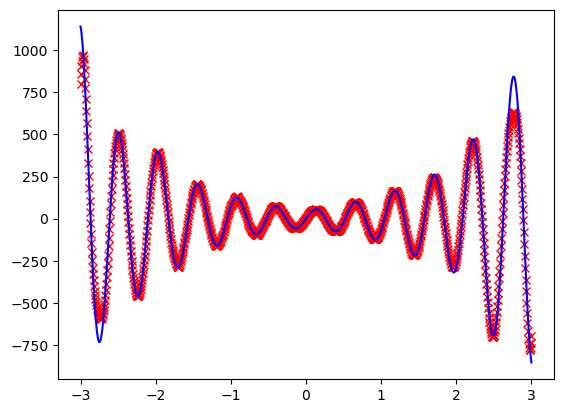

In [11]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [12]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

IndexError: list index out of range